### Setups

In [245]:
import time
import torch

from torch import nn, Tensor

# flow_matching

import sys
sys.path.append("/home/haselab/projects/sakai_ssd/FlowAD/flow_matching")

from flow_matching.path.scheduler import CondOTScheduler
from flow_matching.path import AffineProbPath
from flow_matching.solver import Solver, ODESolver
from flow_matching.utils import ModelWrapper
from tqdm import tqdm

# visualization
import matplotlib.pyplot as plt

from matplotlib import cm


# To avoide meshgrid warning
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module='torch')

import os

CUDA_VISIBLE_DEVICES = "7"
os.environ["CUDA_VISIBLE_DEVICES"] = CUDA_VISIBLE_DEVICES

In [246]:
if torch.cuda.is_available():
    device = 'cuda:0'
    print('Using gpu')
else:
    device = 'cpu'
    print('Using cpu.')

Using gpu


### Dataset

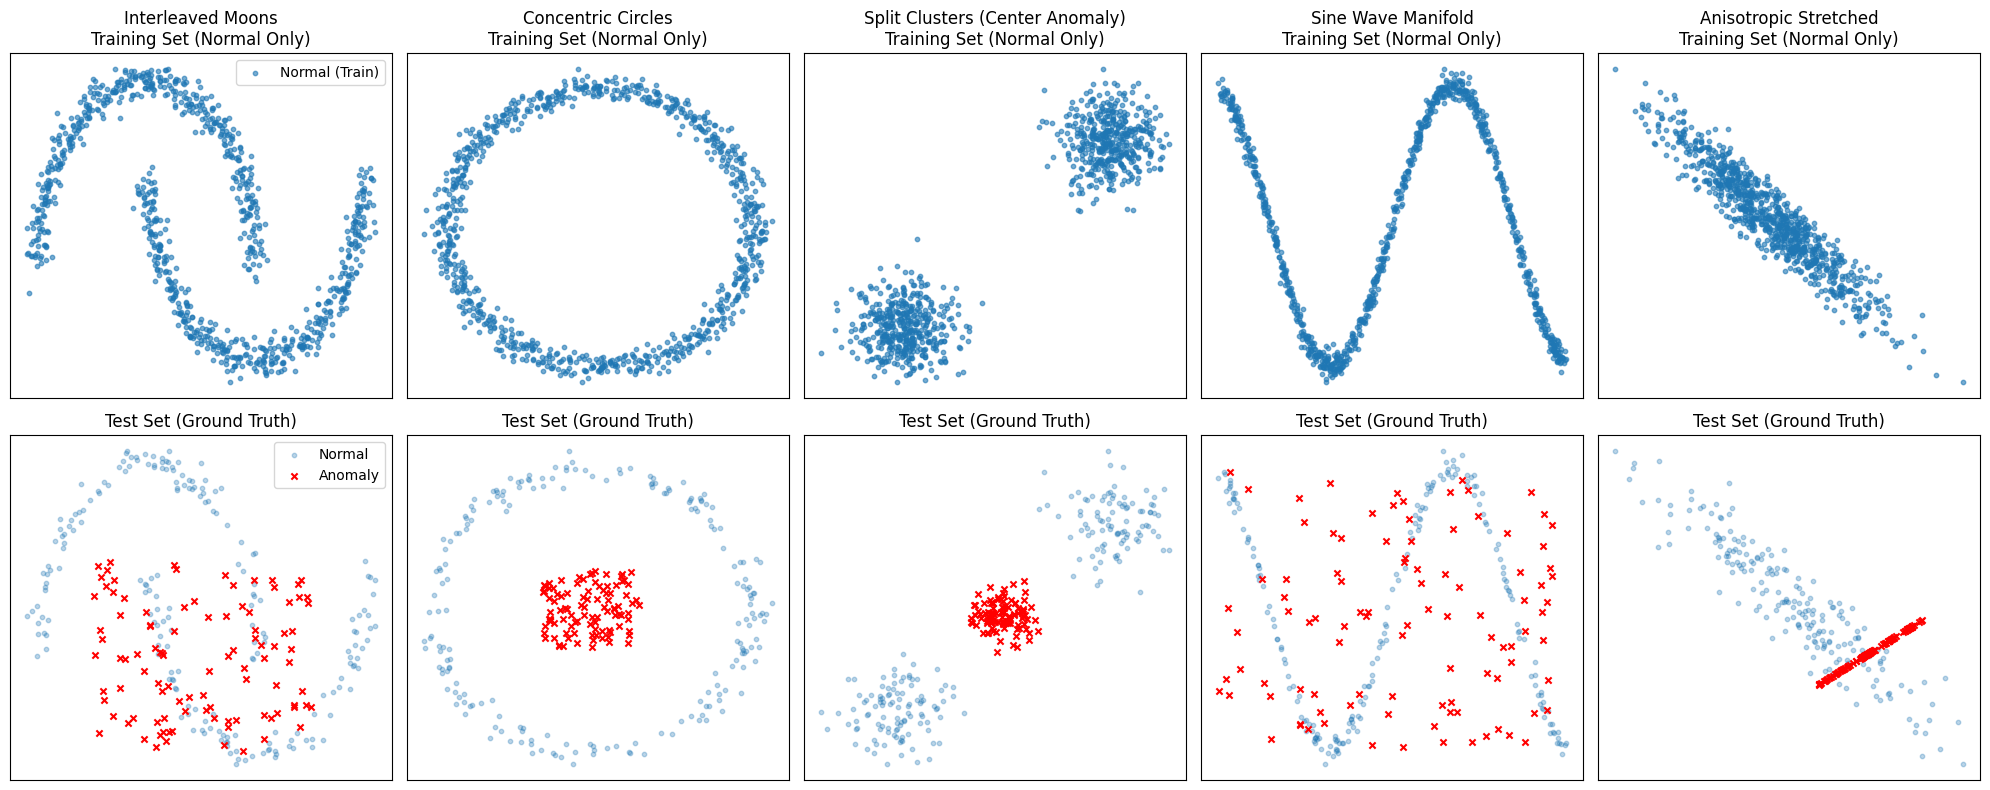

In [247]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_circles, make_blobs

torch.manual_seed(42)
np.random.seed(42)

def generate_toy_dataset(task_id, n_samples=1000, contamination=0.1):
    """
    Generates specific 2D anomaly detection datasets.
    Returns:
        X_train: (numpy array) Training data (only normal samples).
        X_test:  (numpy array) Test data (normal + anomalies).
        y_test:  (numpy array) Test labels (0=normal, 1=anomaly).
    """
    n_anom = int(n_samples * contamination)
    n_norm = n_samples - n_anom
    
    # --- Task 1: The "Moons" (Non-linear manifold) ---
    if task_id == 1:
        # Normal: Standard Moons
        X, _ = make_moons(n_samples=n_norm, noise=0.05, random_state=42)
        # Anomaly: A cluster in the center gap of the moons
        X_anom = np.random.uniform(low=[-0.5, -0.5], high=[1.5, 0.5], size=(n_anom, 2))
        title = "Interleaved Moons"

    # --- Task 2: The "Donut" (Concentric Circles) ---
    elif task_id == 2:
        # Normal: Outer ring
        X, _ = make_circles(n_samples=n_norm, factor=0.5, noise=0.04, random_state=42)
        X = X[_, :] # Only keep the outer ring (index 1 is inner, usually)
        # Actually make_circles returns both, let's just generate a large ring manually for clarity
        t = np.linspace(0, 2*np.pi, n_norm)
        X = np.c_[np.cos(t), np.sin(t)] + np.random.normal(0, 0.05, (n_norm, 2))
        
        # Anomaly: The hole in the middle
        X_anom = np.random.uniform(low=-0.3, high=0.3, size=(n_anom, 2))
        title = "Concentric Circles"

    # --- Task 3: The "Split Blobs" (Multi-modal) ---
    elif task_id == 3:
        # Normal: Two distinct blobs far apart
        X, _ = make_blobs(n_samples=n_norm, centers=[[-2, -2], [2, 2]], cluster_std=0.5, random_state=42)
        # Anomaly: In the "global center" (0,0) where L2 distance to mean is minimal
        X_anom = np.random.normal(loc=0, scale=0.3, size=(n_anom, 2))
        title = "Split Clusters (Center Anomaly)"

    # --- Task 4: The "Sine Wave" (Thin Manifold) ---
    elif task_id == 4:
        # Normal: Follows a sine wave
        x_axis = np.sort(np.random.uniform(-3, 3, n_norm))
        y_axis = np.sin(x_axis * 1.5) + np.random.normal(0, 0.05, n_norm)
        X = np.c_[x_axis, y_axis]
        
        # Anomaly: Uniform noise box around the wave
        X_anom = np.random.uniform(low=[-3, -1], high=[3, 1], size=(n_anom, 2))
        title = "Sine Wave Manifold"

    # --- Task 5: Anisotropic Blob (Variance Dependency) ---
    elif task_id == 5:
        # Normal: Diagonally stretched blob
        X = np.random.normal(0, 1, (n_norm, 2))
        transformation = [[0.6, -0.6], [-0.4, 0.8]] # Stretch matrix
        X = np.dot(X, transformation)
        
        # Anomaly: Points that are close in L2 distance, but off the main axis
        # We place them perpendicular to the correlation
        t = np.random.uniform(-1, 1, n_anom)
        X_anom = np.c_[t + 1.5, t - 1.5] * 0.5 # Shifted slightly off axis
        title = "Anisotropic Stretched"
        
    else:
        raise ValueError("Task ID must be 1-5")

    # Construct Datasets
    # Train: Only Normal
    X_train = X.copy()
    
    # Test: Mix of Normal and Anomalies
    # We take a subset of normal for test to keep sizes consistent
    idx = np.random.choice(len(X), size=n_anom*2, replace=False)
    X_test_normal = X[idx]
    
    X_test = np.vstack([X_test_normal, X_anom])
    y_test = np.hstack([np.zeros(len(X_test_normal)), np.ones(len(X_anom))]) # 0=Normal, 1=Anomaly
    
    return X_train, X_test, y_test, title

# --- Visualization Code ---
def plot_all_tasks():
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    
    for i in range(1, 6):
        X_train, X_test, y_test, title = generate_toy_dataset(i)
        
        # Row 0: Training Data (What the model sees during training)
        ax_train = axes[0, i-1]
        ax_train.scatter(X_train[:, 0], X_train[:, 1], s=10, alpha=0.6, label='Normal (Train)', c='#1f77b4')
        ax_train.set_title(f"{title}\nTraining Set (Normal Only)")
        ax_train.set_xticks([])
        ax_train.set_yticks([])
        if i == 1: ax_train.legend()

        # Row 1: Test Data (Ground Truth)
        ax_test = axes[1, i-1]
        # Plot Normal Test
        ax_test.scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], s=10, c='#1f77b4', alpha=0.3, label='Normal')
        # Plot Anomalies
        ax_test.scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], s=20, c='red', marker='x', label='Anomaly')
        
        ax_test.set_title(f"Test Set (Ground Truth)")
        ax_test.set_xticks([])
        ax_test.set_yticks([])
        if i == 1: 
            ax_test.legend()

    plt.tight_layout()
    plt.show()

plot_all_tasks()

In [420]:
task_id = 1  # Change this to select different datasets (1-5)
num_train_samples = 100000
batch_size = 128

X_train, X_test, y_test, dataset_title = generate_toy_dataset(task_id, n_samples=num_train_samples)

X_train = torch.tensor(X_train, dtype=torch.float32, device=device)
X_test = torch.tensor(X_test, dtype=torch.float32, device=device)
y_test = torch.tensor(y_test, dtype=torch.float32, device=device)

# Dataset Class
class Toy2DDataset(torch.utils.data.Dataset):
    def __init__(self, data: Tensor, label=None, split="train", device='cuda'):
        self.data = data
        self.label = label
        self.split = split
        
        if self.split == "train":
            self.label = torch.zeros(len(data), dtype=torch.float32, device=device)  # All normal for training
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.label[idx]
    
train_dataset = Toy2DDataset(X_train, split="train", device=device)
test_dataset = Toy2DDataset(X_test, label=y_test, split="test", device=device)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Dataset: {dataset_title}")
print(f"Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")

Dataset: Interleaved Moons
Train samples: 90000, Test samples: 30000


### Velocity model

In [394]:
# Activation class
class Swish(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x: Tensor) -> Tensor: 
        return torch.sigmoid(x) * x

# Model class
class MLP(nn.Module):
    def __init__(self, input_dim: int = 2, time_dim: int = 1, hidden_dim: int = 128):
        super().__init__()
        
        self.input_dim = input_dim
        self.time_dim = time_dim
        self.hidden_dim = hidden_dim

        self.main = nn.Sequential(
            nn.Linear(input_dim+time_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, input_dim),
            )
    

    def forward(self, x: Tensor, t: Tensor) -> Tensor:
        sz = x.size()
        x = x.reshape(-1, self.input_dim)
        t = t.reshape(-1, self.time_dim).float()

        t = t.reshape(-1, 1).expand(x.shape[0], 1)
        h = torch.cat([x, t], dim=1)
        output = self.main(h)
        
        return output.reshape(*sz)
    
class SkipMLP(nn.Module):
    def __init__(self, input_dim: int = 2, time_dim: int = 1, hidden_dim: int = 128):
        super().__init__()
        
        self.input_dim = input_dim
        self.time_dim = time_dim
        self.hidden_dim = hidden_dim

        self.layers = nn.ModuleList([
            nn.Linear(input_dim+time_dim, hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Linear(hidden_dim, input_dim),
        ])
        self.act = Swish()
        
    
    def forward(self, x: Tensor, t: Tensor) -> Tensor:
        sz = x.size()
        x = x.reshape(-1, self.input_dim)
        t = t.reshape(-1, self.time_dim).float()

        t = t.reshape(-1, 1).expand(x.shape[0], 1)
        h = torch.cat([x, t], dim=1)
        
        # first layer
        h = self.layers[0](h)
        h = self.act(h)
        
        # hidden layers with skip connections
        for layer in self.layers[1:-1]:
            h_in = h
            h = layer(h)
            h = self.act(h)
            h = h + h_in  # Skip connection
        output = self.layers[-1](h)
        return output.reshape(*sz)

### Training Velocity model

In [353]:
# training arguments
lr = 0.001
hidden_dim = 128
epochs = 20
prior_sigma = 1.0

# velocity field model init
vf = MLP(input_dim=2, time_dim=1, hidden_dim=hidden_dim).to(device) 

# instantiate an affine path object
path = AffineProbPath(scheduler=CondOTScheduler())

# init optimizer
optim = torch.optim.Adam(vf.parameters(), lr=lr) 

# train
start_time = time.time()
for epoch in range(epochs):
    
    for (x, _) in train_loader:
        x = x.to(device)
        
        # sample data (user's responsibility): in this case, (X_0,X_1) ~ pi(X_0,X_1) = N(X_0|0,I)q(X_1)
        x_0 = torch.randn_like(x).to(device) 

        # sample time (user's responsibility)
        t = torch.rand(x.shape[0]).to(device) 
        # sample probability path
        path_sample = path.sample(t=t, x_0=x_0, x_1=x)

        # flow matching l2 loss
        loss = torch.pow( vf(path_sample.x_t, path_sample.t) - path_sample.dx_t, 2).mean() 

        # optimizer step
        optim.zero_grad() 
        loss.backward() # backward
        optim.step() # update
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

Epoch 1/20, Loss: 1.1520
Epoch 2/20, Loss: 1.3931
Epoch 3/20, Loss: 1.0209
Epoch 4/20, Loss: 0.6794
Epoch 5/20, Loss: 1.1267
Epoch 6/20, Loss: 1.8016
Epoch 7/20, Loss: 1.5599
Epoch 8/20, Loss: 1.2080
Epoch 9/20, Loss: 1.2156
Epoch 10/20, Loss: 1.3589
Epoch 11/20, Loss: 1.4063
Epoch 12/20, Loss: 1.1635
Epoch 13/20, Loss: 1.2573
Epoch 14/20, Loss: 1.3436
Epoch 15/20, Loss: 1.5725
Epoch 16/20, Loss: 0.9752
Epoch 17/20, Loss: 0.5495
Epoch 18/20, Loss: 0.7902
Epoch 19/20, Loss: 1.0693
Epoch 20/20, Loss: 0.5852


In [354]:
class WrappedModel(ModelWrapper):
    def forward(self, x: torch.Tensor, t: torch.Tensor, **extras):
        return self.model(x, t, **extras)

wrapped_vf = WrappedModel(vf)

### Sampling

In [355]:
# step size for ode solver
step_size = 0.01
method = 'midpoint'

norm = cm.colors.Normalize(vmax=50, vmin=0)

batch_size = 50000  # batch size
eps_time = 1e-2
T = torch.linspace(0,1,10)  # sample times
T = T.to(device=device)

x_init = torch.randn((batch_size, 2), dtype=torch.float32, device=device)  # initial points from prior
solver = ODESolver(velocity_model=wrapped_vf)  # create an ODESolver class
sol_ddpm = solver.sample(time_grid=T, x_init=x_init, method=method, step_size=step_size, return_intermediates=True)  # sample from the model

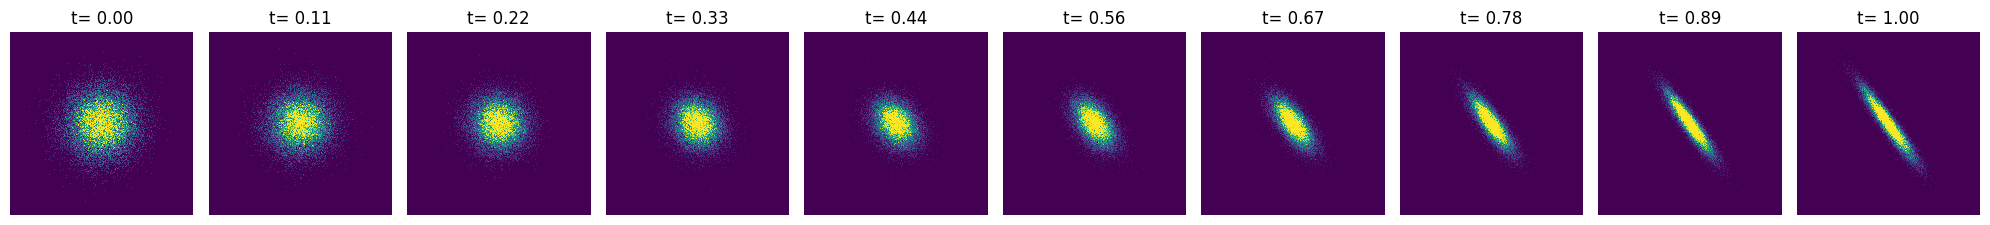

In [356]:
sol_ddpm = sol_ddpm.cpu().numpy()
T = T.cpu()

fig, axs = plt.subplots(1, 10,figsize=(20,20))

for i in range(10):
    H= axs[i].hist2d(sol_ddpm[i,:,0], sol_ddpm[i,:,1], 300, range=((-5,5), (-5,5)))
    
    cmin = 0.0
    cmax = torch.quantile(torch.from_numpy(H[0]), 0.99).item()
    
    norm = cm.colors.Normalize(vmax=cmax, vmin=cmin)
    
    _ = axs[i].hist2d(sol_ddpm[i,:,0], sol_ddpm[i,:,1], 300, range=((-5,5), (-5,5)), norm=norm)
    
    axs[i].set_aspect('equal')
    axs[i].axis('off')
    axs[i].set_title('t= %.2f' % (T[i]))
    
plt.tight_layout()
plt.show()

Optional: Reflow

In [173]:
## Genrate pairs of (x_0, x_1) 
import copy
num_samples = 1000000
gen_batch_size = 10000
step_size = 0.01
method = 'midpoint'
num_reflow_iters = 3

fine_tune_epochs = 50
fine_tune_lr = 0.001
fine_tune_vf = copy.deepcopy(vf).to(device)

for ref_iter in range(num_reflow_iters):
    reflow_samples = []
    t = torch.arange(0.0, 1.0 + step_size, step_size, device=device)
    solver = ODESolver(velocity_model=WrappedModel(fine_tune_vf))
    
    for i in tqdm(range(0, num_samples, gen_batch_size), desc=f"Reflow Iter {ref_iter+1}/{num_reflow_iters} Generating (x0, x1) pairs"):
        bsz = min(gen_batch_size, num_samples - i)
        x_init = torch.randn((bsz, 2), device=device) * prior_sigma
        x_1_samples = solver.sample(time_grid=t, x_init=x_init, method=method, step_size=step_size)
        reflow_samples.extend(zip(x_init.detach().cpu(), x_1_samples.detach().cpu()))
    reflow_samples = np.array(reflow_samples)

    fine_tune_optim = torch.optim.Adam(fine_tune_vf.parameters(), lr=fine_tune_lr)
    for epoch in tqdm(range(fine_tune_epochs), desc=f"Reflow Iter {ref_iter+1}/{num_reflow_iters} Fine-tuning"):
        rand_perm = np.random.permutation(len(reflow_samples))
        for i in range(0, len(reflow_samples), batch_size):
            batch_idx = rand_perm[i:i+batch_size]
            x_0_batch = torch.tensor(reflow_samples[batch_idx,0], dtype=torch.float32, device=device)
            x_1_batch = torch.tensor(reflow_samples[batch_idx,1], dtype=torch.float32, device=device)
            
            t = torch.rand(x_0_batch.shape[0]).to(device) 
            path_sample = path.sample(t=t, x_0=x_0_batch, x_1=x_1_batch)

            loss = torch.pow( fine_tune_vf(path_sample.x_t, path_sample.t) - path_sample.dx_t, 2).mean() 

            fine_tune_optim.zero_grad() 
            loss.backward() 
            fine_tune_optim.step()
    

Reflow Iter 3/3 Fine-tuning: 100%|██████████| 50/50 [00:09<00:00,  5.44it/s]


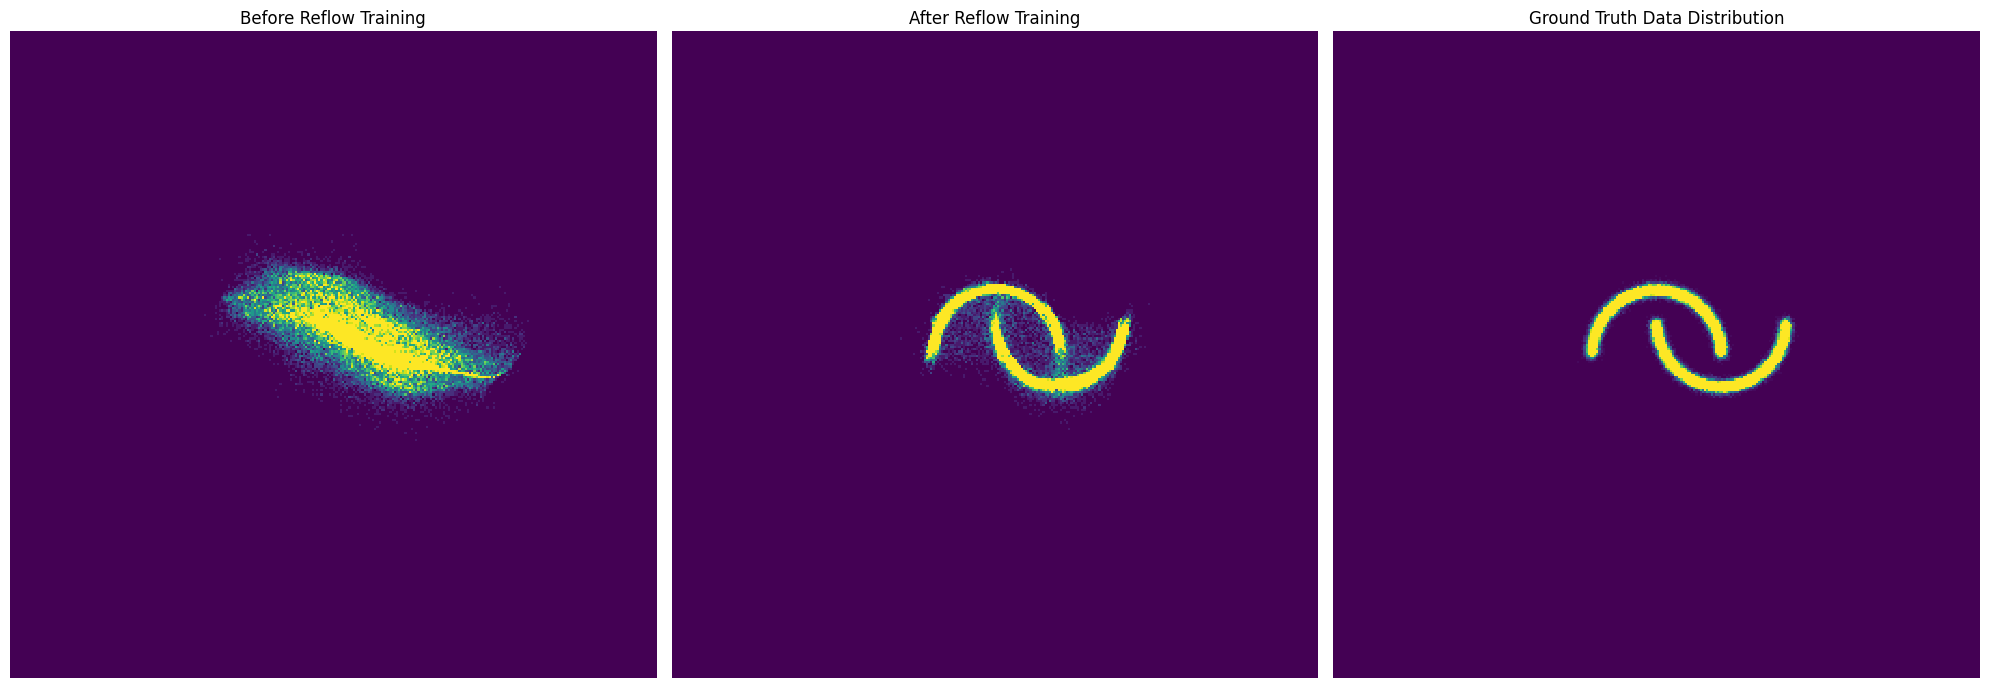

In [175]:
# Sampling after reflow training, just one-step sampling
step_size = 1.0
method = 'midpoint'

x_0 = torch.randn((batch_size, 2), dtype=torch.float32, device=device)  # initial points from prior
solver = ODESolver(velocity_model=WrappedModel(fine_tune_vf))  # create an ODESolver class
solver_ = ODESolver(velocity_model=WrappedModel(vf))  # create an ODESolver class for original model

x_1_samples = solver.sample(time_grid=torch.tensor([0.0,1.0], device=device), x_init=x_0, method=method, step_size=step_size)  # sample from the model
x_1_samples = x_1_samples.cpu().numpy()

x_1_samples_ = solver_.sample(time_grid=torch.tensor([0.0,1.0], device=device), x_init=x_0, method=method, step_size=step_size)  # sample from the original model
x_1_samples_ = x_1_samples_.cpu().numpy()

norm = cm.colors.Normalize(vmax=50, vmin=0)
fig, axs = plt.subplots(1, 3,figsize=(20,20))
# before reflow
H= axs[0].hist2d(x_1_samples_[:,0], x_1_samples_[:,1], 300, range=((-5,5), (-5,5)))
cmin = 0.0
cmax = torch.quantile(torch.from_numpy(H[0]), 0.99).item()
norm = cm.colors.Normalize(vmax=cmax, vmin=cmin)
_ = axs[0].hist2d(x_1_samples_[:,0], x_1_samples_[:,1], 300, range=((-5,5), (-5,5)), norm=norm)
axs[0].set_aspect('equal')
axs[0].axis('off')
axs[0].set_title('Before Reflow Training')

# after reflow
H= axs[1].hist2d(x_1_samples[:,0], x_1_samples[:,1], 300, range=((-5,5), (-5,5)))
cmin = 0.0
cmax = torch.quantile(torch.from_numpy(H[0]), 0.99).item()
norm = cm.colors.Normalize(vmax=cmax, vmin=cmin)
_ = axs[1].hist2d(x_1_samples[:,0], x_1_samples[:,1], 300, range=((-5,5), (-5,5)), norm=norm)
axs[1].set_aspect('equal')
axs[1].axis('off')
axs[1].set_title('After Reflow Training')

# ground truth
H= axs[2].hist2d(X_train.cpu().numpy()[:,0], X_train.cpu().numpy()[:,1], 300, range=((-5,5), (-5,5)))
cmin = 0.0
cmax = torch.quantile(torch.from_numpy(H[0]), 0.99).item()
norm = cm.colors.Normalize(vmax=cmax, vmin=cmin)
_ = axs[2].hist2d(X_train.cpu().numpy()[:,0], X_train.cpu().numpy()[:,1], 300, range=((-5,5), (-5,5)), norm=norm)
axs[2].set_aspect('equal')
axs[2].axis('off')
axs[2].set_title('Ground Truth Data Distribution')


plt.tight_layout()
plt.show()

### Anomaly Detection with Density Estimation

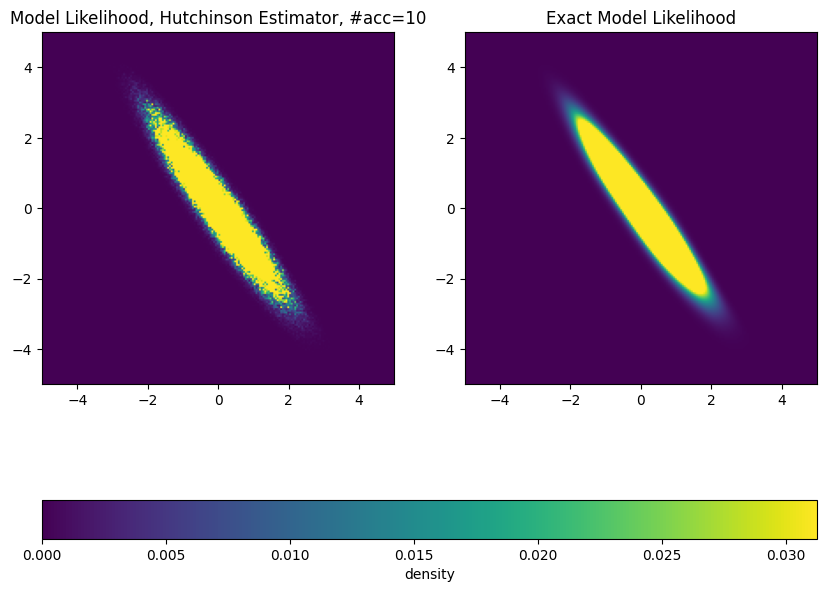

In [357]:
from torch.distributions import Independent, Normal

T = torch.tensor([1., 0.])  # sample times
T = T.to(device=device)

gaussian_log_density = Independent(Normal(torch.zeros(2, device=device), torch.ones(2, device=device)), 1).log_prob
num_acc = 10
log_p_acc = 0
step_size = 0.05

solver = ODESolver(velocity_model=WrappedModel(vf))

grid_size = 200
x_1 = torch.meshgrid(torch.linspace(-5, 5, grid_size), torch.linspace(-5, 5, grid_size))
x_1 = torch.stack([x_1[0].flatten(), x_1[1].flatten()], dim=1).to(device)

# Hutchinson's trace estimator
for i in range(num_acc):
    _, log_p = solver.compute_likelihood(x_1=x_1, method='midpoint', step_size=step_size, exact_divergence=False, log_p0=gaussian_log_density)
    log_p_acc += log_p
log_p_acc /= num_acc

# Exact divergence computation
_, exact_log_p = solver.compute_likelihood(x_1=x_1, method='midpoint', step_size=step_size, exact_divergence=True, log_p0=gaussian_log_density)

likelihood = torch.exp(log_p_acc).cpu().reshape(grid_size, grid_size).detach().numpy()
exact_likelihood = torch.exp(exact_log_p).cpu().reshape(grid_size, grid_size).detach().numpy()
    
fig, axs = plt.subplots(1, 2,figsize=(10,10))
cmin = 0.0
cmax = 1/32 # 1/32 is the gt likelihood value

norm = cm.colors.Normalize(vmax=cmax, vmin=cmin)

axs[0].imshow(likelihood.T, extent=(-5, 5, -5, 5), origin='lower', cmap='viridis', norm=norm)
axs[0].set_title('Model Likelihood, Hutchinson Estimator, #acc=%d' % num_acc)

axs[1].imshow(exact_likelihood.T, extent=(-5, 5, -5, 5), origin='lower', cmap='viridis', norm=norm)
axs[1].set_title('Exact Model Likelihood')

fig.colorbar(cm.ScalarMappable(norm=norm, cmap='viridis'), ax=axs, orientation='horizontal', label='density')
plt.show()

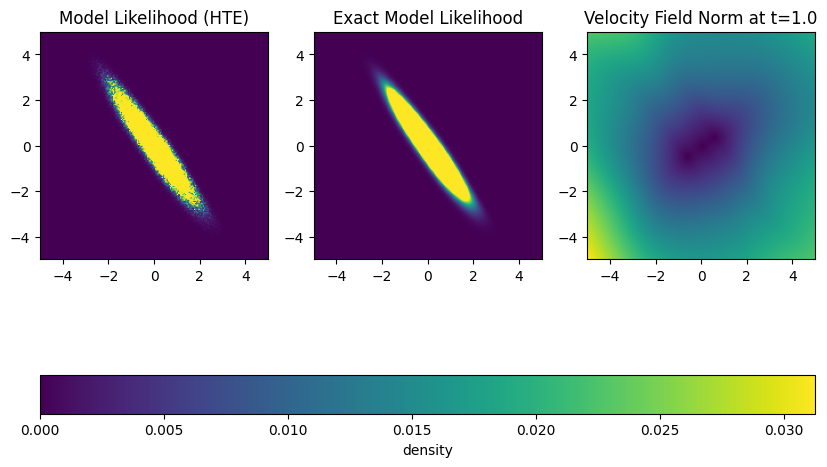

In [358]:
# Also we plot the norm of velocity field

T = torch.tensor([1.0, 0.])  # sample times
T = T.to(device=device)

wrapped_vf = WrappedModel(vf)

grid_size = 200
x_1 = torch.meshgrid(torch.linspace(-5, 5, grid_size), torch.linspace(-5, 5, grid_size))
x_1 = torch.stack([x_1[0].flatten(), x_1[1].flatten()], dim=1).to(device)

# Exact divergence computation
with torch.no_grad():
    v = wrapped_vf.model(x_1, T[0].expand(x_1.shape[0]))
    v_norm = torch.norm(v, dim=1) 
    
fig, axs = plt.subplots(1, 3,figsize=(10,10))
cmin = 0.0
cmax = 1/32 # 1/32 is the gt likelihood value

norm = cm.colors.Normalize(vmax=cmax, vmin=cmin)

axs[0].imshow(likelihood.T, extent=(-5, 5, -5, 5), origin='lower', cmap='viridis', norm=norm)
axs[0].set_title('Model Likelihood (HTE)')

axs[1].imshow(exact_likelihood.T, extent=(-5, 5, -5, 5), origin='lower', cmap='viridis', norm=norm)
axs[1].set_title('Exact Model Likelihood')

axs[2].imshow(v_norm.cpu().reshape(grid_size, grid_size).T, extent=(-5, 5, -5, 5), origin='lower', cmap='viridis')
axs[2].set_title('Velocity Field Norm at t=1.0')

fig.colorbar(cm.ScalarMappable(norm=norm, cmap='viridis'), ax=axs, orientation='horizontal', label='density')
plt.show()

In [359]:
class WrappedModel(ModelWrapper):
    def forward(self, x: torch.Tensor, t: torch.Tensor, **extras):
        return self.model(x, t, **extras)

wrapped_vf = WrappedModel(vf)

# instantiate an affine path object
path = AffineProbPath(scheduler=CondOTScheduler())
solver = ODESolver(velocity_model=wrapped_vf)  # create an ODESolver class

In [360]:

anomaly_scores = []
score_norms = []
gt_labels = []

method = 'midpoint'
trace_estimator = 'exact'  # 'hutchinson' or 'exact'
exact_divergence = True if trace_estimator == 'exact' else False
hutchinson_acc = 10  # number of Hutchinson trace estimator samples
step_size = 0.05

for (x, labels) in tqdm(test_loader):
    x = x.to(device)
    labels = labels.to(device)
    x.requires_grad = True
    
    batch_size = x.shape[0]
    if not exact_divergence:
        # Hutchinson's trace estimator
        log_p_acc = 0
        for i in range(hutchinson_acc):
            _, log_p = solver.compute_likelihood(x_1=x, method=method, step_size=step_size, exact_divergence=exact_divergence, log_p0=gaussian_log_density)
            log_p_acc += log_p
        log_p = log_p_acc / hutchinson_acc
    else:
        _, log_p = solver.compute_likelihood(x_1=x, method=method, step_size=step_size, exact_divergence=exact_divergence, log_p0=gaussian_log_density, enable_grad=True)
    grad_x = torch.autograd.grad(outputs=log_p.sum(), inputs=x, create_graph=False, retain_graph=False)[0]
    grad_norm = grad_x.view(batch_size, -1).norm(p=2, dim=1)
    
    score_norms.append(grad_norm.detach().cpu())
    anomaly_scores.append(-log_p.detach().cpu())
    gt_labels.append(labels.detach().cpu())

anomaly_scores = torch.cat(anomaly_scores).numpy()
score_norms = torch.cat(score_norms).numpy()
gt_labels = torch.cat(gt_labels).numpy()


100%|██████████| 235/235 [00:33<00:00,  6.97it/s]


In [361]:
# Metrics computation
from sklearn.metrics import roc_auc_score, average_precision_score
roc_auc = roc_auc_score(gt_labels, anomaly_scores)
avg_precision = average_precision_score(gt_labels, anomaly_scores)
print(f"Anomaly Detection Results on {dataset_title}:")
print(f"ROC AUC: {roc_auc:.4f}, Average Precision: {avg_precision:.4f}")

roc_auc = roc_auc_score(gt_labels, score_norms)
avg_precision = average_precision_score(gt_labels, score_norms)
print(f"Score Norms Anomaly Detection Results on {dataset_title}:")
print(f"ROC AUC: {roc_auc:.4f}, Average Precision: {avg_precision:.4f}")

Anomaly Detection Results on Anisotropic Stretched:
ROC AUC: 0.7637, Average Precision: 0.6631
Score Norms Anomaly Detection Results on Anisotropic Stretched:
ROC AUC: 0.7505, Average Precision: 0.6684


In [362]:
# Anomaly scoring with norm of velocity field
anomaly_scores = []
gt_labels = []

timesteps = torch.tensor([1.0]).to(device)

for (x, labels) in tqdm(test_loader):
    x = x.to(device)
    labels = labels.to(device)
    
    batch_size = x.shape[0]
    with torch.no_grad():
        v = wrapped_vf.model(x, timesteps[0].expand(x.shape[0]))
        v_norm = torch.norm(v, dim=1)
    
    anomaly_scores.extend(v_norm.detach().cpu().numpy())
    gt_labels.extend(labels.detach().cpu().numpy())

anomaly_scores = torch.tensor(anomaly_scores).numpy()
gt_labels = torch.tensor(gt_labels).numpy()

100%|██████████| 235/235 [00:00<00:00, 736.77it/s]


In [363]:
# Metrics computation
from sklearn.metrics import roc_auc_score, average_precision_score
roc_auc = roc_auc_score(gt_labels, anomaly_scores)
avg_precision = average_precision_score(gt_labels, anomaly_scores)
print(f"Anomaly Detection Results on {dataset_title}:")
print(f"ROC AUC: {roc_auc:.4f}, Average Precision: {avg_precision:.4f}")

Anomaly Detection Results on Anisotropic Stretched:
ROC AUC: 0.5860, Average Precision: 0.3404


### Anomaly Detection with Reconstruction Error

In [264]:
class WrappedModel(ModelWrapper):
    def forward(self, x: torch.Tensor, t: torch.Tensor, **extras):
        return self.model(x, t, **extras)

wrapped_vf = WrappedModel(vf)

# instantiate an affine path object
path = AffineProbPath(scheduler=CondOTScheduler())

In [265]:
# Reconstruction for anomalous and normal samples
all_samples = [(x, y) for (x, y) in test_dataset]
X_test = torch.stack([x for (x, _) in all_samples], dim=0)
y_test = torch.tensor([y for (_, y) in all_samples], dtype=torch.float32)

normal_samples = X_test[y_test == 0].to(device)
anomalous_samples = X_test[y_test == 1].to(device)

num_samples = 100
test_batch = torch.cat([normal_samples[:num_samples//2], anomalous_samples[:num_samples//2]], dim=0)
x_test = test_batch.to(device)  
y_test = torch.cat([torch.zeros(num_samples//2), torch.ones(num_samples//2)], dim=0)

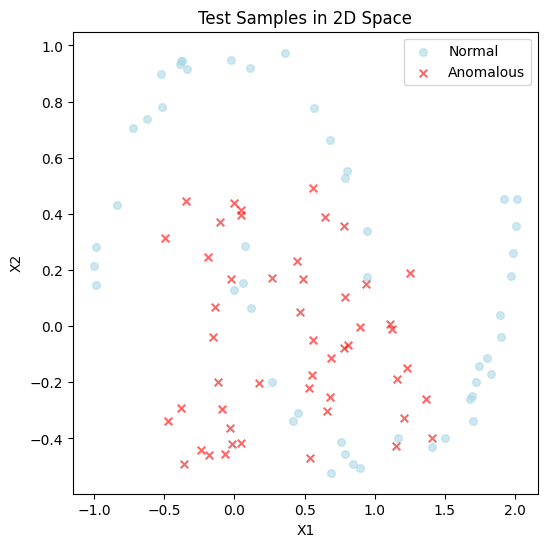

In [266]:
# Plot x_test in 2D space
plt.figure(figsize=(6, 6))
plt.scatter(x_test[y_test==0, 0].cpu(), x_test[y_test==0, 1].cpu(), s=30, c='lightblue', alpha=0.6, label='Normal', marker='o')
plt.scatter(x_test[y_test==1, 0].cpu(), x_test[y_test==1, 1].cpu(), s=30, c='red', alpha=0.6, label='Anomalous', marker='x')
plt.title('Test Samples in 2D Space')
plt.xlabel('X1')
plt.ylabel('X2')
plt.legend()
plt.show()

In [267]:
# First, we plot the trajectries X_1 -> X_t (i.e., perturbation trajectories)
x_0 = torch.randn_like(x_test).to(device)  # noise
x_1 = x_test.to(device)  # data point
x_1_normal = x_1[y_test==0]
x_1_anomalous = x_1[y_test==1]

t_grid = torch.linspace(0.0, 0.99, 10).to(device)
x_t_list = []
for t in t_grid:
    path_sample = path.sample(t=t.repeat(x_1.shape[0]), x_0=x_0, x_1=x_1)
    x_t_list.append(path_sample.x_t.detach().cpu().numpy())

x_t_array = np.stack(x_t_list, axis=0)  # shape: (num_times, batch_size, 2)
x_t_array_normal = x_t_array[:, :num_samples//2, :]
x_t_array_anomalous = x_t_array[:, num_samples//2:, :]

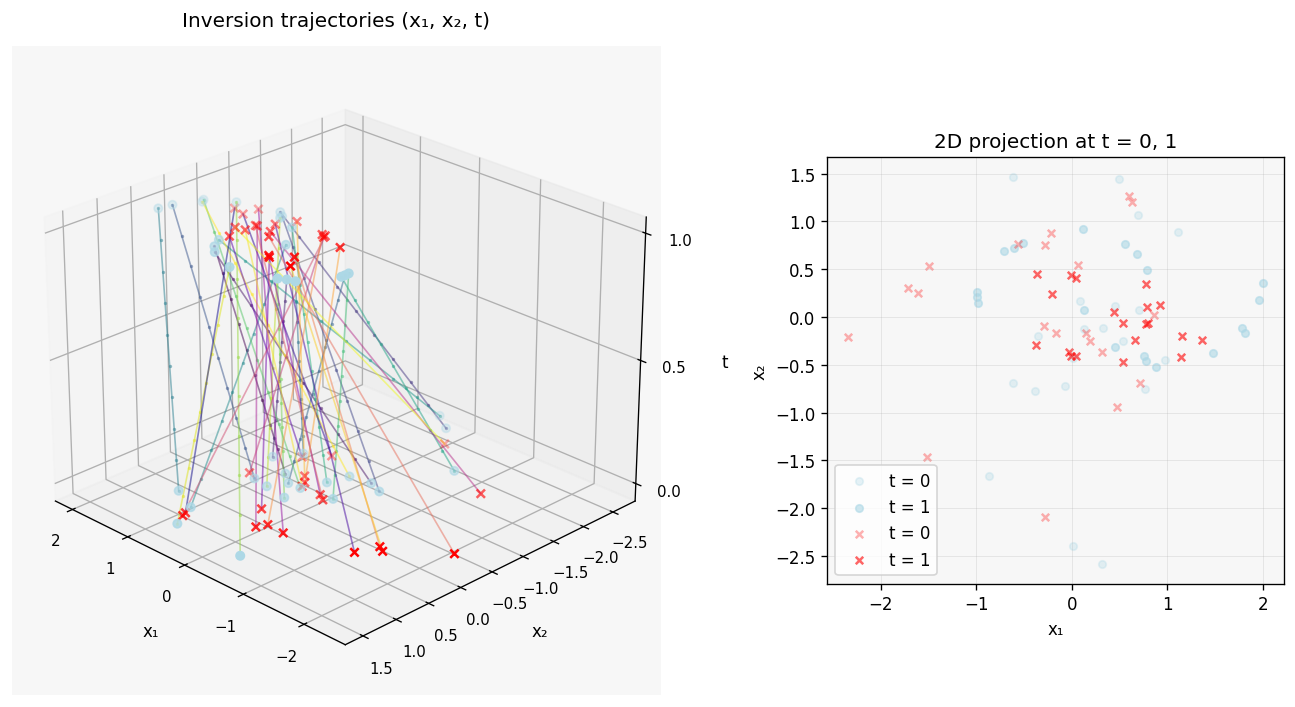

In [268]:
from matplotlib import cm
import matplotlib.pyplot as plt

num_times, batch_size, _ = x_t_array.shape
t_np = t_grid.detach().cpu().numpy()
num_traj = 20

fig = plt.figure(figsize=(12, 6), dpi=120)
gs = fig.add_gridspec(1, 2, width_ratios=[2, 1])  

ax = fig.add_subplot(gs[0, 0], projection='3d')  
ax2 = fig.add_subplot(gs[0, 1])                  

ax.set_facecolor("#f7f7f7")      
fig.patch.set_facecolor("white") 
ax.grid(True, linewidth=0.3, alpha=0.5)

colors = cm.viridis(np.linspace(0, 1, num_traj))
# plot trajectories for normal samples
for n, c in zip(range(num_traj), colors):
    ax.plot(x_t_array_normal[:, n, 0], x_t_array_normal[:, n, 1], t_np, color=c, alpha=0.5, linewidth=1.0, marker='o', markersize=2, markeredgewidth=0.0)

colors = cm.plasma(np.linspace(0, 1, num_traj))
# plot trajectories for anomalous samples
for n, c in zip(range(num_traj), colors):
    ax.plot(x_t_array_anomalous[:, n, 0], x_t_array_anomalous[:, n, 1], t_np, color=c, alpha=0.5, linewidth=1.0, marker='x', markersize=2, markeredgewidth=0.0)

ax.scatter(x_t_array_normal[0, :num_traj, 0], x_t_array_normal[0, :num_traj, 1], t_np[0], s=25, c="lightblue", marker="o", label="t = 0")
ax.scatter(x_t_array_normal[-1, :num_traj, 0], x_t_array_normal[-1, :num_traj, 1], t_np[-1], s=25, c="lightblue", marker="o", label="t = 1")

ax.scatter(x_t_array_anomalous[0, :num_traj, 0], x_t_array_anomalous[0, :num_traj, 1], t_np[0], s=25, c="red", marker="x", label="t = 0")
ax.scatter(x_t_array_anomalous[-1, :num_traj, 0], x_t_array_anomalous[-1, :num_traj, 1], t_np[-1], s=25, c="red", marker="x", label="t = 1")

ax.set_xlabel("x₁", labelpad=8)
ax.set_ylabel("x₂", labelpad=8)
ax.set_zlabel("t",  labelpad=8)

ax.set_zticks([0.0, 0.5, 1.0])
ax.tick_params(labelsize=9)

ax.view_init(elev=25, azim=135)
ax.set_title("Inversion trajectories (x₁, x₂, t)", pad=12)

ax2.set_facecolor("#f7f7f7")
ax2.grid(True, linewidth=0.3, alpha=0.5)

ax2.scatter(x_t_array_normal[0, :num_traj, 0], x_t_array_normal[0, :num_traj, 1], s=20, c="lightblue", label="t = 0", marker="o", alpha=0.3)
ax2.scatter(x_t_array_normal[-1, :num_traj, 0], x_t_array_normal[-1, :num_traj, 1], s=20, c="lightblue", label="t = 1", marker="o", alpha=0.6)

ax2.scatter(x_t_array_anomalous[0, :num_traj, 0], x_t_array_anomalous[0, :num_traj, 1], s=20, c="red", label="t = 0", marker="x", alpha=0.3)
ax2.scatter(x_t_array_anomalous[-1, :num_traj, 0], x_t_array_anomalous[-1, :num_traj, 1], s=20, c="red", label="t = 1", marker="x", alpha=0.6)

ax2.set_xlabel("x₁")
ax2.set_ylabel("x₂")
ax2.set_aspect("equal")
ax2.set_title("2D projection at t = 0, 1")
ax2.legend()

plt.tight_layout()
plt.show()


In [393]:
# Do reconstruction from x_t to x_0

solver = ODESolver(velocity_model=wrapped_vf)  # create an ODESolver class
x_t_array_torch = torch.tensor(x_t_array, dtype=torch.float32, device=device)
x_1_recon_list = []
y_list = []
step_size = 0.01
method = 'euler'

for i in range(x_t_array_torch.shape[0]):
    x_t = x_t_array_torch[i]
    x_1_recon = solver.sample(time_grid=torch.tensor([t_grid[i], 1.0], device=device), x_init=x_t, method=method, step_size=step_size)
    x_1_recon_list.append(x_1_recon.detach().cpu().numpy())
    
x_1_recon_array = np.stack(x_1_recon_list, axis=0)  # shape: (num_times, batch_size, 2)
x_1_recon_array_normal = x_1_recon_array[:, y_test==0, :]
x_1_recon_array_anomalous = x_1_recon_array[:, y_test==1, :]

t=0.00 | Normal Recon Error: 1.5274, Anomalous Recon Error: 1.8028
t=0.11 | Normal Recon Error: 1.4054, Anomalous Recon Error: 1.6709
t=0.22 | Normal Recon Error: 1.2478, Anomalous Recon Error: 1.5094
t=0.33 | Normal Recon Error: 1.0572, Anomalous Recon Error: 1.3136
t=0.44 | Normal Recon Error: 0.8512, Anomalous Recon Error: 1.0861
t=0.55 | Normal Recon Error: 0.6487, Anomalous Recon Error: 0.8475
t=0.66 | Normal Recon Error: 0.4675, Anomalous Recon Error: 0.6214
t=0.77 | Normal Recon Error: 0.3110, Anomalous Recon Error: 0.4117
t=0.88 | Normal Recon Error: 0.1622, Anomalous Recon Error: 0.2023
t=0.99 | Normal Recon Error: 0.0127, Anomalous Recon Error: 0.0149


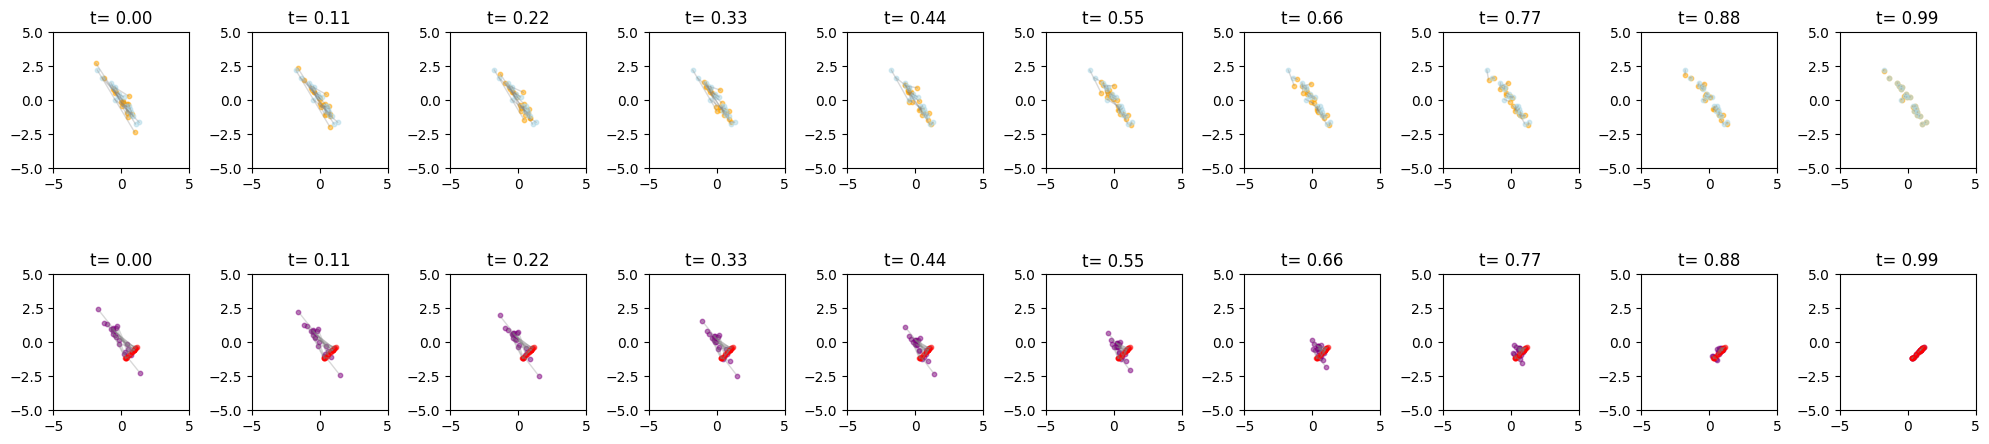

In [394]:
fig, axs = plt.subplots(2, 10, figsize=(20, 5))
num_plot_points = 20

x_1_normal_np = x_1_normal[:num_plot_points].detach().cpu().numpy()
x_1_anomalous_np = x_1_anomalous[:num_plot_points].detach().cpu().numpy()

for i in range(10):
    x_1_recon_normal_np = x_1_recon_array_normal[i, :num_plot_points, :]
    x_1_recon_anomalous_np = x_1_recon_array_anomalous[i, :num_plot_points, :]
    
    # calculate reconstruction error
    recon_error_normal = np.linalg.norm(x_1_recon_normal_np - x_1_normal_np, axis=1)
    recon_error_anomalous = np.linalg.norm(x_1_recon_anomalous_np - x_1_anomalous_np, axis=1)
    print(f"t={t_grid[i]:.2f} | Normal Recon Error: {recon_error_normal.mean():.4f}, Anomalous Recon Error: {recon_error_anomalous.mean():.4f}")

    axs[0, i].scatter(x_1_recon_normal_np[:, 0], x_1_recon_normal_np[:, 1],
                      s=10, c='orange', alpha=0.5, label=r'$\hat{x}_0$ (reconstructed)')
    axs[1, i].scatter(x_1_recon_anomalous_np[:, 0], x_1_recon_anomalous_np[:, 1],
                      s=10, c='purple', alpha=0.5, label=r'$\hat{x}_0$ (reconstructed)')

    axs[0, i].scatter(x_1_normal_np[:, 0], x_1_normal_np[:, 1],
                      s=10, c='lightblue', alpha=0.5, label=r'$x_1$ (original)')
    axs[1, i].scatter(x_1_anomalous_np[:, 0], x_1_anomalous_np[:, 1],
                      s=10, c='red', alpha=0.5, label=r'$x_1$ (original)')

    for j in range(num_plot_points):
        axs[0, i].plot(
            [x_1_normal_np[j, 0], x_1_recon_normal_np[j, 0]],
            [x_1_normal_np[j, 1], x_1_recon_normal_np[j, 1]],
            c='gray', alpha=0.3, linewidth=1.0
        )

    for j in range(num_plot_points):
        axs[1, i].plot(
            [x_1_anomalous_np[j, 0], x_1_recon_anomalous_np[j, 0]],
            [x_1_anomalous_np[j, 1], x_1_recon_anomalous_np[j, 1]],
            c='gray', alpha=0.3, linewidth=1.0
        )

    axs[0, i].set_title(f't= {t_grid[i]:.2f}')
    axs[0, i].set_xlim([-5, 5])
    axs[0, i].set_ylim([-5, 5])
    axs[0, i].set_aspect('equal')

    axs[1, i].set_title(f't= {t_grid[i]:.2f}')
    axs[1, i].set_xlim([-5, 5])
    axs[1, i].set_ylim([-5, 5])
    axs[1, i].set_aspect('equal')
    
    

plt.tight_layout()
plt.show()

In [395]:
# Calculate reconstruction MSE for normal and anomalous samples at different t
mse_normal = []
mse_anomaly = []
scores_norm = []

t_np = t_grid.detach().cpu().numpy()

# redefine test loader with smaller batch size for reconstruction
recon_batch_size = len(test_dataset)
test_loader_recon = torch.utils.data.DataLoader(test_dataset, batch_size=recon_batch_size, shuffle=False)

x_0 = torch.randn((recon_batch_size, 2), dtype=torch.float32, device=device)  # noise
for i in tqdm(range(x_t_array_torch.shape[0])):
    total_mse_normal = 0.0
    total_mse_anomaly = 0.0
    num_normal_samples = 0
    num_anomaly_samples = 0
    scores_at_t = []
    gt_labels = []
    for (x, y) in test_loader_recon:
        y = y.detach().cpu().numpy()
        gt_labels.extend(y.tolist())
        x_1 = x.to(device)
        
        # Perturb to time t
        path_sample = path.sample(t=t_grid[i].repeat(x_1.shape[0]), x_0=x_0, x_1=x_1) 
        x_t = path_sample.x_t
        
        # Reconstruct to x_0
        x_1_recon = solver.sample(time_grid=torch.tensor([t_grid[i], 1.0], device=device), x_init=x_t, method=method, step_size=step_size)
        
        # Compute MSE
        recon_error = np.linalg.norm(x_1_recon.detach().cpu().numpy() - x_1.detach().cpu().numpy(), axis=1)
        total_mse_normal += np.sum(recon_error[y == 0])  # normal samples
        total_mse_anomaly += np.sum(recon_error[y == 1])  # anomaly samples
        scores_at_t += recon_error.tolist()
        
        num_normal_samples += np.sum(y == 0)
        num_anomaly_samples += np.sum(y == 1)
        
    scores_norm.append(scores_at_t)
    # Average over batches
    mse_normal_avg = total_mse_normal / num_normal_samples
    mse_anomaly_avg = total_mse_anomaly / num_anomaly_samples
    mse_normal.append(mse_normal_avg)
    mse_anomaly.append(mse_anomaly_avg)

100%|██████████| 10/10 [00:05<00:00,  1.71it/s]


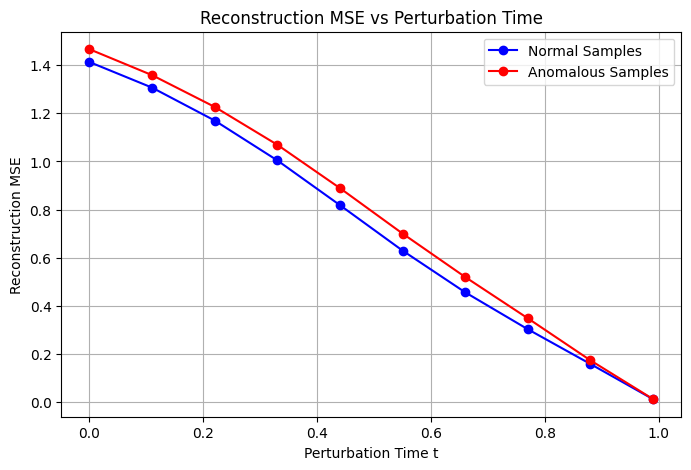

In [396]:
# plot MSE results
plt.figure(figsize=(8, 5))
plt.plot(t_np, mse_normal, marker='o', label='Normal Samples', color='blue')
plt.plot(t_np, mse_anomaly, marker='o', label='Anomalous Samples', color='red')
plt.xlabel('Perturbation Time t')
plt.ylabel('Reconstruction MSE')
plt.title('Reconstruction MSE vs Perturbation Time')
plt.legend()
plt.grid(True)

In [397]:
# Calculate AUC and AP based on reconstruction errors at each t
from sklearn.metrics import roc_auc_score, average_precision_score

for i in range(len(t_np)):
    scores_at_t = np.array(scores_norm[i])
    roc_auc_t = roc_auc_score(gt_labels, scores_at_t)
    avg_precision_t = average_precision_score(gt_labels, scores_at_t)
    print(f"t = {t_np[i]:.2f} => ROC AUC: {roc_auc_t:.4f}, Average Precision: {avg_precision_t:.4f}")

t = 0.00 => ROC AUC: 0.5335, Average Precision: 0.3387
t = 0.11 => ROC AUC: 0.5329, Average Precision: 0.3397
t = 0.22 => ROC AUC: 0.5354, Average Precision: 0.3428
t = 0.33 => ROC AUC: 0.5415, Average Precision: 0.3482
t = 0.44 => ROC AUC: 0.5511, Average Precision: 0.3559
t = 0.55 => ROC AUC: 0.5633, Average Precision: 0.3664
t = 0.66 => ROC AUC: 0.5753, Average Precision: 0.3807
t = 0.77 => ROC AUC: 0.5769, Average Precision: 0.3942
t = 0.88 => ROC AUC: 0.5467, Average Precision: 0.3775
t = 0.99 => ROC AUC: 0.5145, Average Precision: 0.3494


### Anomaly Detection with Inversion

In [364]:
class WrappedModel(ModelWrapper):
    def forward(self, x: torch.Tensor, t: torch.Tensor, **extras):
        return self.model(x, t, **extras)

wrapped_vf = WrappedModel(vf)

# instantiate an affine path object
path = AffineProbPath(scheduler=CondOTScheduler())
solver = ODESolver(velocity_model=wrapped_vf)  # create an ODESolver class

In [365]:
# Reconstruction for anomalous and normal samples
all_samples = [(x, y) for (x, y) in test_dataset]
X_test = torch.stack([x for (x, _) in all_samples], dim=0)
y_test = torch.tensor([y for (_, y) in all_samples], dtype=torch.float32)

normal_samples = X_test[y_test == 0].to(device)
anomalous_samples = X_test[y_test == 1].to(device)

num_samples = 1000
test_batch = torch.cat([normal_samples[:num_samples//2], anomalous_samples[:num_samples//2]], dim=0)
x_test = test_batch.to(device)  
y_test = torch.cat([torch.zeros(num_samples//2), torch.ones(num_samples//2)], dim=0)

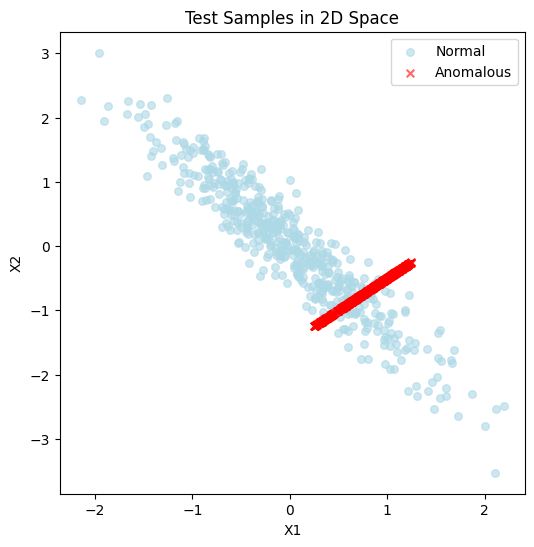

In [366]:
# Plot x_test in 2D space
plt.figure(figsize=(6, 6))
plt.scatter(x_test[y_test==0, 0].cpu(), x_test[y_test==0, 1].cpu(), s=30, c='lightblue', alpha=0.6, label='Normal', marker='o')
plt.scatter(x_test[y_test==1, 0].cpu(), x_test[y_test==1, 1].cpu(), s=30, c='red', alpha=0.6, label='Anomalous', marker='x')
plt.title('Test Samples in 2D Space')
plt.xlabel('X1')
plt.ylabel('X2')
plt.legend()
plt.show()

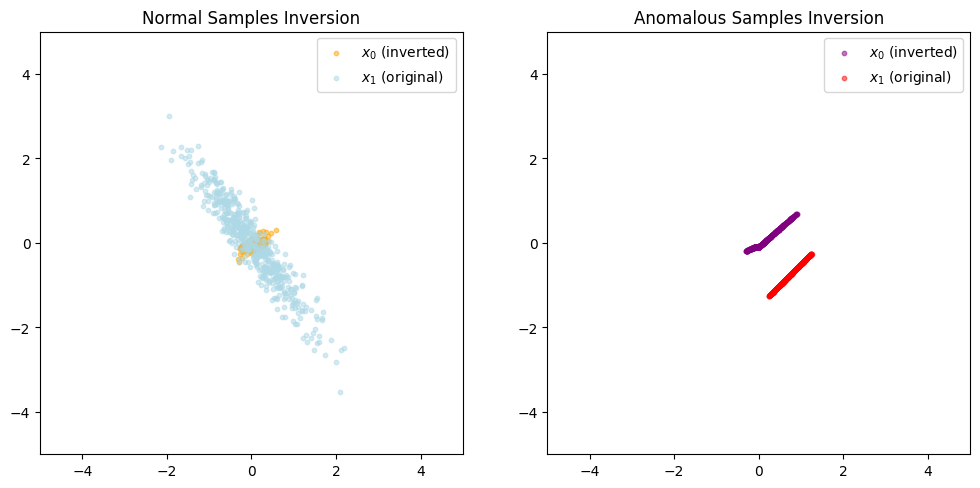

In [367]:
# Do inversion from x_1 to x_0

x_1 = x_test.to(device)  # data point
end_t = 0.0
t_grid = torch.tensor([1.0, end_t], device=device)
step_size = 1.0
method = 'euler'

x_0 = solver.sample(time_grid=t_grid, x_init=x_1, method=method, step_size=step_size)
velocity = wrapped_vf.model(x_1, t_grid[0].expand(x_1.shape[0])).detach().cpu().numpy()

x_0_np = x_0.detach().cpu().numpy()
x_1_np = x_1.detach().cpu().numpy()

term = -2 * np.sum(x_1_np * velocity, axis=1)

x_0_normal = x_0_np[y_test==0]
x_0_anomalous = x_0_np[y_test==1]
x_1_normal = x_1_np[y_test==0]
x_1_anomalous = x_1_np[y_test==1]

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].scatter(x_0_normal[:, 0], x_0_normal[:, 1],
               s=10, c='orange', alpha=0.5, label=r'$x_0$ (inverted)')
axs[0].scatter(x_1_normal[:, 0], x_1_normal[:, 1],
               s=10, c='lightblue', alpha=0.5, label=r'$x_1$ (original)')
axs[0].set_title('Normal Samples Inversion')
axs[0].set_xlim([-5, 5])
axs[0].set_ylim([-5, 5])
axs[0].set_aspect('equal')
axs[0].legend()

axs[1].scatter(x_0_anomalous[:, 0], x_0_anomalous[:, 1],
               s=10, c='purple', alpha=0.5, label=r'$x_0$ (inverted)')
axs[1].scatter(x_1_anomalous[:, 0], x_1_anomalous[:, 1],
               s=10, c='red', alpha=0.5, label=r'$x_1$ (original)')
axs[1].set_title('Anomalous Samples Inversion')
axs[1].set_xlim([-5, 5])
axs[1].set_ylim([-5, 5])
axs[1].set_aspect('equal')
axs[1].legend()

In [368]:
import math
scores = []
labels = []

t_grid = torch.tensor([1.0, end_t], device=device)
step_size = 1.0
method = 'euler'

for (x, y) in test_loader:
    x = x.to(device)
    y = y.to(device)
    
    x_0 = solver.sample(time_grid=t_grid, x_init=x, method=method, step_size=step_size)
    v = wrapped_vf.model(x, t_grid[0].expand(x.shape[0])).detach().cpu().numpy()
    v_norm = np.linalg.norm(v, axis=1)
    cosine = -2 * np.sum(x.detach().cpu().numpy() * v, axis=1)
    x_1_norm = np.linalg.norm(x.detach().cpu().numpy(), axis=1)
    
    x_0_np = x_0.detach().cpu().numpy()
    
    dim = x_0_np.shape[1]
    scores_batch_norm = np.linalg.norm(x_0_np, axis=1)
    
    scores.extend(scores_batch_norm.tolist())
    labels.extend(y.detach().cpu().numpy().tolist())
    
# Anomaly detection metrics
from sklearn.metrics import roc_auc_score, average_precision_score
roc_auc = roc_auc_score(torch.tensor(labels).numpy(), scores)
avg_precision = average_precision_score(torch.tensor(labels).numpy(), scores)
print(f"Inversion Anomaly Detection Results on {dataset_title}:")
print(f"ROC AUC: {roc_auc:.4f}, Average Precision: {avg_precision:.4f}")

Inversion Anomaly Detection Results on Anisotropic Stretched:
ROC AUC: 0.6464, Average Precision: 0.5836


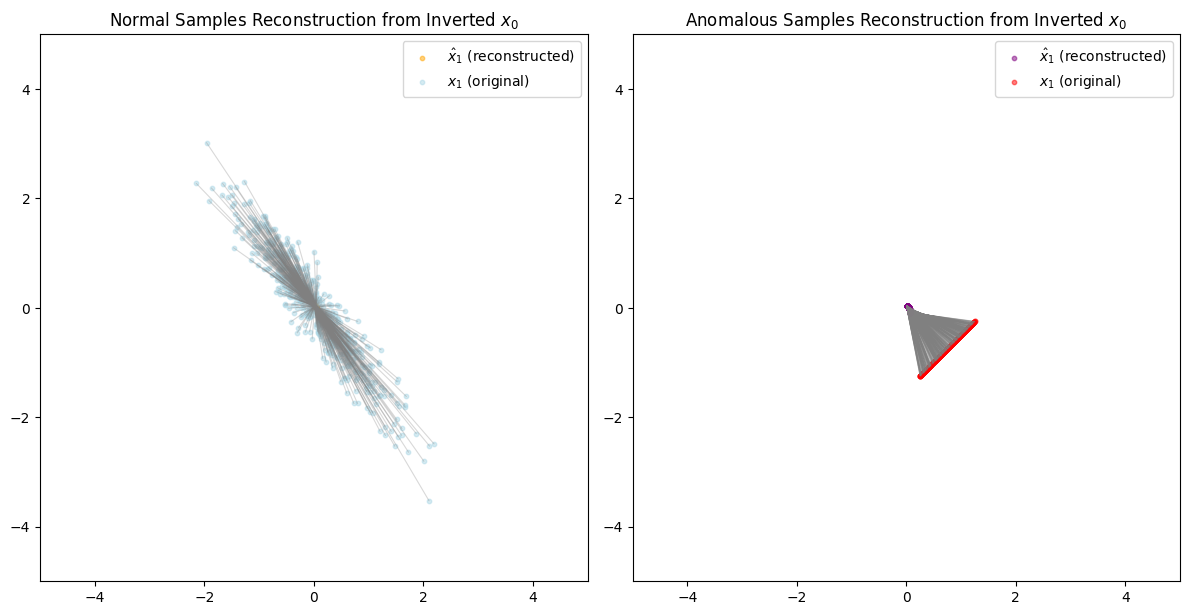

In [369]:
# Reconstruction from Inverted x_0 to x_1
x_0 = solver.sample(time_grid=t_grid, x_init=x_1, method=method, step_size=step_size)

x_1_recon = solver.sample(
    time_grid=t_grid.flip(0),
    x_init=x_0, method=method, step_size=step_size
)
x_1_recon_np = x_1_recon.detach().cpu().numpy()

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

idx_normal = (y_test == 0)
idx_anom = (y_test == 1)

axs[0].scatter(x_1_recon_np[idx_normal, 0],
               x_1_recon_np[idx_normal, 1],
               s=10, c='orange', alpha=0.5, label=r'$\hat{x}_1$ (reconstructed)')
axs[0].scatter(x_1_normal[:, 0], x_1_normal[:, 1],
               s=10, c='lightblue', alpha=0.5, label=r'$x_1$ (original)')

for (x_rec, x_orig) in zip(x_1_recon_np[idx_normal], x_1_normal):
    axs[0].plot([x_rec[0], x_orig[0]], [x_rec[1], x_orig[1]],
                c='gray', alpha=0.3, linewidth=0.8)

axs[0].set_title('Normal Samples Reconstruction from Inverted $x_0$')
axs[0].set_xlim([-5, 5])
axs[0].set_ylim([-5, 5])
axs[0].set_aspect('equal')
axs[0].legend()

axs[1].scatter(x_1_recon_np[idx_anom, 0],
               x_1_recon_np[idx_anom, 1],
               s=10, c='purple', alpha=0.5, label=r'$\hat{x}_1$ (reconstructed)')
axs[1].scatter(x_1_anomalous[:, 0], x_1_anomalous[:, 1],
               s=10, c='red', alpha=0.5, label=r'$x_1$ (original)')

for (x_rec, x_orig) in zip(x_1_recon_np[idx_anom], x_1_anomalous):
    axs[1].plot([x_rec[0], x_orig[0]], [x_rec[1], x_orig[1]],
                c='gray', alpha=0.3, linewidth=0.8)

axs[1].set_title('Anomalous Samples Reconstruction from Inverted $x_0$')
axs[1].set_xlim([-5, 5])
axs[1].set_ylim([-5, 5])
axs[1].set_aspect('equal')
axs[1].legend()

plt.tight_layout()
plt.show()

In [370]:
scores_norm = np.linalg.norm(x_1_np - x_1_recon_np, axis=1)
# Anomaly detection metrics
roc_auc = roc_auc_score(y_test.numpy(), scores_norm)
average_precision = average_precision_score(y_test.numpy(), scores_norm)
print(f"Reconstruction from Inverted x0 Anomaly Detection Results on {dataset_title}:")
print(f"ROC AUC: {roc_auc:.4f}, Average Precision: {average_precision:.4f}")

Reconstruction from Inverted x0 Anomaly Detection Results on Anisotropic Stretched:
ROC AUC: 0.6288, Average Precision: 0.5137


100%|██████████| 7/7 [00:16<00:00,  2.29s/it]


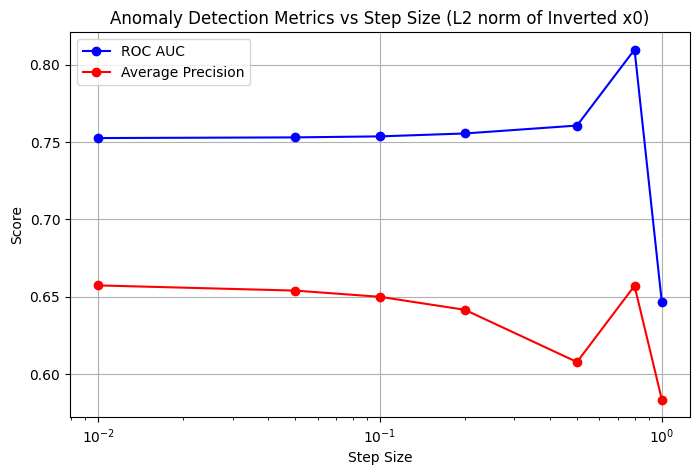

In [378]:
# Plot how AUC and AP vary with different step sizes
step_sizes = [1.0, 0.8, 0.5, 0.2, 0.1, 0.05, 0.01]
roc_aucs = []
avg_precisions = []

for step_size in tqdm(step_sizes):
    
    t_grid = torch.tensor([1.0, end_t], device=device)
    method = 'euler'
    
    scores = []
    labels = []
    
    for (x_1, y_test) in test_loader:
        
        x_1 = x_1.to(device)
        y_test = y_test.to(device)
    
        x_0 = solver.sample(time_grid=t_grid, x_init=x_1, method=method, step_size=step_size)
        x_0_np = x_0.detach().cpu().numpy()
        scores_norm = np.linalg.norm(x_0_np, axis=1)
        
        scores.extend(scores_norm.tolist())
        labels.extend(y_test.detach().cpu().numpy().tolist())
        
    roc_auc = roc_auc_score(torch.tensor(labels).numpy(), scores)
    avg_precision = average_precision_score(torch.tensor(labels).numpy(), scores)
    
    roc_aucs.append(roc_auc)
    avg_precisions.append(avg_precision)

plt.figure(figsize=(8, 5))
plt.plot(step_sizes, roc_aucs, marker='o', label='ROC AUC', color='blue')
plt.plot(step_sizes, avg_precisions, marker='o', label='Average Precision', color='red')
plt.xscale('log')
plt.xlabel('Step Size')
plt.ylabel('Score')
plt.title('Anomaly Detection Metrics vs Step Size (L2 norm of Inverted x0)')
plt.legend()
plt.grid(True)
plt.show()

In [379]:
# each auc and ap value
for i, step_size in enumerate(step_sizes):
    print(f"Step Size: {step_size:.4f} | Inversion ROC AUC: {roc_aucs[i]:.4f}, Average Precision: {avg_precisions[i]:.4f}")

Step Size: 1.0000 | Inversion ROC AUC: 0.6464, Average Precision: 0.5836
Step Size: 0.8000 | Inversion ROC AUC: 0.8097, Average Precision: 0.6571
Step Size: 0.5000 | Inversion ROC AUC: 0.7606, Average Precision: 0.6078
Step Size: 0.2000 | Inversion ROC AUC: 0.7555, Average Precision: 0.6416
Step Size: 0.1000 | Inversion ROC AUC: 0.7536, Average Precision: 0.6500
Step Size: 0.0500 | Inversion ROC AUC: 0.7530, Average Precision: 0.6540
Step Size: 0.0100 | Inversion ROC AUC: 0.7526, Average Precision: 0.6573


100%|██████████| 7/7 [00:29<00:00,  4.16s/it]


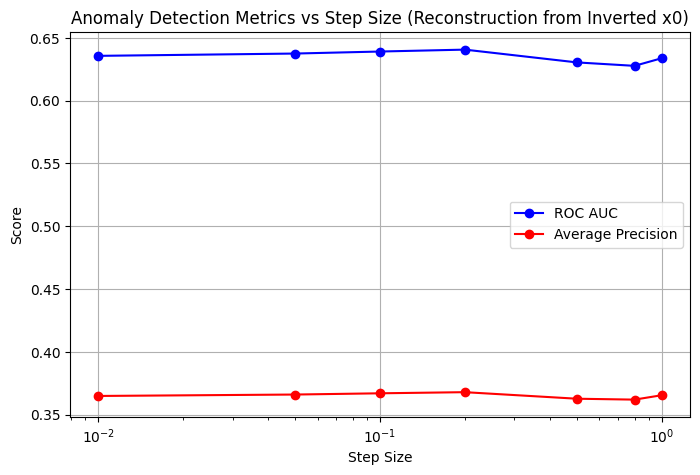

In [375]:
# how AUC and AP vary with different step sizes
roc_aucs = []
avg_precisions = []
for step_size in tqdm(step_sizes):
    scores = []
    labels = []
    for (x_1, y_test) in test_loader:
        
        x_1 = x_1.to(device)
        y_test = y_test.to(device)
        
        x_0 = solver.sample(time_grid=t_grid, x_init=x_1, method=method, step_size=step_size)
        x_1_recon = solver.sample(
            time_grid=t_grid.flip(0),
            x_init=x_0, method=method, step_size=step_size
        )
        x_1_recon_np = x_1_recon.detach().cpu().numpy()
        x_1_np = x_1.detach().cpu().numpy()
        scores_norm = np.linalg.norm(x_1_np - x_1_recon_np, axis=1)
        scores.extend(scores_norm.tolist())
        labels.extend(y_test.detach().cpu().numpy().tolist())
        
    roc_auc = roc_auc_score(torch.tensor(labels).numpy(), scores)
    avg_precision = average_precision_score(torch.tensor(labels).numpy(), scores)
    
    roc_aucs.append(roc_auc)
    avg_precisions.append(avg_precision)

plt.figure(figsize=(8, 5))
plt.plot(step_sizes, roc_aucs, marker='o', label='ROC AUC', color='blue')
plt.plot(step_sizes, avg_precisions, marker='o', label='Average Precision', color='red')
plt.xscale('log')
plt.xlabel('Step Size')
plt.ylabel('Score')
plt.title('Anomaly Detection Metrics vs Step Size (Reconstruction from Inverted x0)')
plt.legend()
plt.grid(True)
plt.show()

In [350]:
# each auc and ap value
for i, step_size in enumerate(step_sizes):
    print(f"Step Size: {step_size:.4f} | Inversion ROC AUC: {roc_aucs[i]:.4f}, Average Precision: {avg_precisions[i]:.4f}")

Step Size: 1.0000 | Inversion ROC AUC: 0.5523, Average Precision: 0.4320
Step Size: 0.8000 | Inversion ROC AUC: 0.5108, Average Precision: 0.3766
Step Size: 0.5000 | Inversion ROC AUC: 0.4788, Average Precision: 0.3432
Step Size: 0.2000 | Inversion ROC AUC: 0.6401, Average Precision: 0.5451
Step Size: 0.1000 | Inversion ROC AUC: 0.7426, Average Precision: 0.7064
Step Size: 0.0500 | Inversion ROC AUC: 0.7740, Average Precision: 0.7545
Step Size: 0.0100 | Inversion ROC AUC: 0.7934, Average Precision: 0.7834


In [36]:
all_samples = [(x, y) for (x, y) in test_dataset]
X_test = torch.stack([x for (x, _) in all_samples], dim=0)
y_test = torch.tensor([y for (_, y) in all_samples], dtype=torch.float32)

normal_samples = X_test[y_test == 0].to(device)
anomalous_samples = X_test[y_test == 1].to(device)

num_samples = 1000
test_batch = torch.cat([normal_samples[:num_samples//2], anomalous_samples[:num_samples//2]], dim=0)
x_test = test_batch.to(device)  
y_test = torch.cat([torch.zeros(num_samples//2), torch.ones(num_samples//2)], dim=0)

In [37]:
# Inversion Trajectories Visualization
step_size = 1
t = torch.arange(0.0, 1.0 + step_size, step_size, device=device).flip(0)
method = 'euler'

inv_traj = solver.sample(time_grid=t, x_init=x_test, method=method, step_size=None, return_intermediates=True)
# (num_times+1, batch_size, 2)
inv_traj_np = inv_traj.cpu().numpy()
y_test_np = y_test.cpu().numpy()

inv_traj_normal = inv_traj_np[:, y_test_np==0, :]
inv_traj_anomalous = inv_traj_np[:, y_test_np==1, :]

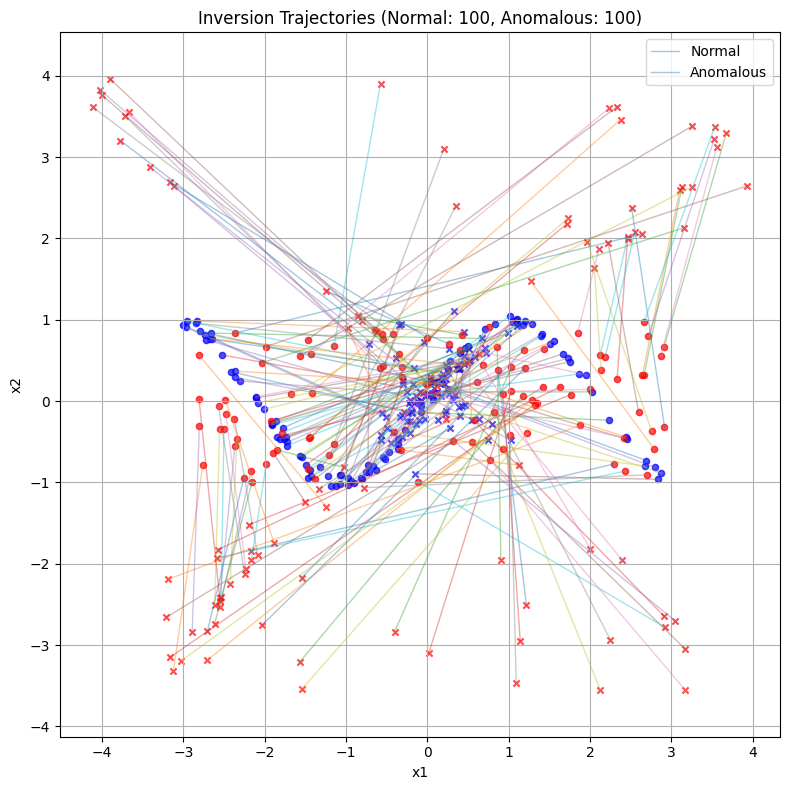

In [38]:
import matplotlib.pyplot as plt

# 可視化する本数
N = 100  # 好きな数に変えてください

# それぞれからサンプルする本数（データ数より多く指定してもOKなように調整）
n_normal = inv_traj_normal.shape[1]
n_anom   = inv_traj_anomalous.shape[1]

N_normal = min(N, n_normal)
N_anom   = min(N, n_anom)

# 乱数シード（再現性が欲しければ固定）
rng = np.random.default_rng(seed=0)

idx_normal = rng.choice(n_normal, size=N_normal, replace=False)
idx_anom   = rng.choice(n_anom, size=N_anom, replace=False)

plt.figure(figsize=(8, 8))

# ===== Normal の軌跡 =====
for i in idx_normal:
    traj = inv_traj_normal[:, i, :]  # shape: (num_times+1, 2)
    x = traj[:, 0]
    y = traj[:, 1]
    # 初期点→中間点→終着点まで全てを結んだ軌跡
    plt.plot(x, y, alpha=0.4, linewidth=1.0, label='Normal' if i == idx_normal[0] else "")

    # 初期点と終着点を目立たせたい場合（任意）
    plt.scatter(x[0],  y[0],  s=20, marker='o', alpha=0.7, color='blue')  # start
    plt.scatter(x[-1], y[-1], s=20, marker='x', alpha=0.7, color='blue')  # end

# ===== Anomalous の軌跡 =====
for i in idx_anom:
    traj = inv_traj_anomalous[:, i, :]  # shape: (num_times+1, 2)
    x = traj[:, 0]
    y = traj[:, 1]
    plt.plot(x, y, alpha=0.4, linewidth=1.0, label='Anomalous' if i == idx_anom[0] else "")

    # 初期点と終着点（任意）
    plt.scatter(x[0],  y[0],  s=20, marker='o', alpha=0.7, color='red')  # start
    plt.scatter(x[-1], y[-1], s=20, marker='x', alpha=0.7, color='red')  # end

plt.xlabel('x1')
plt.ylabel('x2')
plt.axis('equal')
plt.legend()
plt.title(f'Inversion Trajectories (Normal: {N_normal}, Anomalous: {N_anom})')
plt.grid(True)
plt.tight_layout()
plt.show()


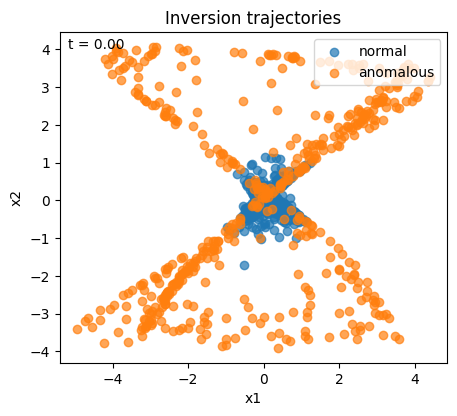

In [39]:
from matplotlib.animation import FuncAnimation

num_steps = inv_traj_np.shape[0] 

x_min = inv_traj_np[..., 0].min()
x_max = inv_traj_np[..., 0].max()
y_min = inv_traj_np[..., 1].min()
y_max = inv_traj_np[..., 1].max()

pad_x = 0.05 * (x_max - x_min + 1e-8)
pad_y = 0.05 * (y_max - y_min + 1e-8)
x_min, x_max = x_min - pad_x, x_max + pad_x
y_min, y_max = y_min - pad_y, y_max + pad_y

fig, ax = plt.subplots(figsize=(5, 5))

scat_normal = ax.scatter([], [], label="normal", alpha=0.7)
scat_anom   = ax.scatter([], [], label="anomalous", alpha=0.7)

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_title("Inversion trajectories")
ax.legend(loc="upper right")
ax.set_aspect("equal", adjustable="box")

time_text = ax.text(0.02, 0.95, "", transform=ax.transAxes)

t_np = t.cpu().numpy() if isinstance(t, torch.Tensor) else np.asarray(t)


def init():
    scat_normal.set_offsets(np.empty((0, 2)))
    scat_anom.set_offsets(np.empty((0, 2)))
    time_text.set_text("")
    return scat_normal, scat_anom, time_text


def update(frame):
    if inv_traj_normal.shape[1] > 0:
        scat_normal.set_offsets(inv_traj_normal[frame])
    else:
        scat_normal.set_offsets(np.empty((0, 2)))

    if inv_traj_anomalous.shape[1] > 0:
        scat_anom.set_offsets(inv_traj_anomalous[frame])
    else:
        scat_anom.set_offsets(np.empty((0, 2)))

    if frame < len(t_np):
        time_text.set_text(f"t = {t_np[frame]:.2f}")
    else:
        time_text.set_text(f"step = {frame}")

    return scat_normal, scat_anom, time_text


ani = FuncAnimation(
    fig,
    update,
    frames=num_steps,
    init_func=init,
    interval=50, 
    blit=True
)

ani.save("inv_traj.mp4", fps=30)

In [179]:

# Get inversion trajectories
step_size = 0.001
t = torch.arange(0.0, 1.0 + step_size, step_size, device=device).flip(0)
method = 'euler'

inv_traj = solver.sample(time_grid=t, x_init=x_test, method=method, step_size=None, return_intermediates=True)
# (num_times+1, batch_size, 2)
inv_traj_np = inv_traj.cpu().numpy()
inv_traj_normal = inv_traj_np[:, y_test==0, :]
inv_traj_anomalous = inv_traj_np[:, y_test==1, :]

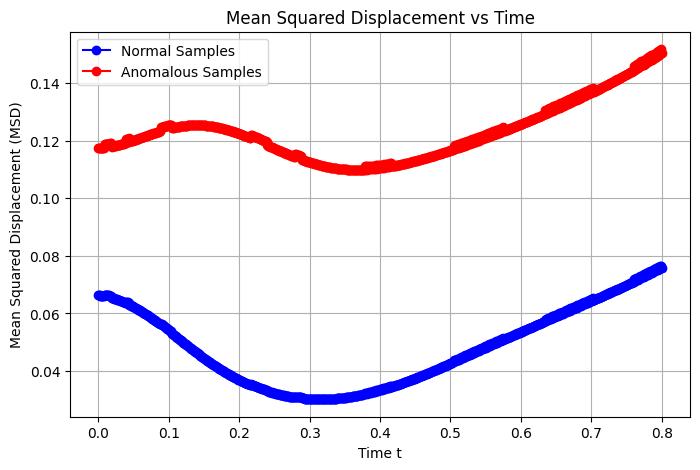

In [180]:
# Mean squared displacement over time
msd_normal = []
msd_anomalous = []

inv_traj_normal = inv_traj_np[:, y_test==0, :]
inv_traj_anomalous = inv_traj_np[:, y_test==1, :]

tau = 0.2  # time lag
t_np = np.arange(0.0, 1.0 + step_size, step_size)

for i in range(inv_traj_np.shape[0]):
    t_current = t_np[i]
    t_lagged = t_current + tau
    if t_lagged > 1.0:
        msd_normal.append(np.nan)
        msd_anomalous.append(np.nan)
        continue

    idx_lagged = np.searchsorted(t_np, t_lagged)

    diffs_normal = inv_traj_normal[idx_lagged] - inv_traj_normal[i]
    diffs_anomalous = inv_traj_anomalous[idx_lagged] - inv_traj_anomalous[i]

    msd_normal.append(np.mean(np.sum(diffs_normal**2, axis=1)))
    msd_anomalous.append(np.mean(np.sum(diffs_anomalous**2, axis=1)))
    
plt.figure(figsize=(8, 5))
plt.plot(t_np, msd_normal, marker='o', label='Normal Samples', color='blue')
plt.plot(t_np, msd_anomalous, marker='o', label='Anomalous Samples', color='red')
plt.xlabel('Time t')
plt.ylabel('Mean Squared Displacement (MSD)')
plt.title('Mean Squared Displacement vs Time')
plt.legend()
plt.grid(True)
plt.show()

In [181]:
# per sample MSD averaged over time
scores = []
labels = []
tau = 0.1  # time lag
t_np = np.arange(0.0, 1.0 + step_size, step_size)

for (x, y) in tqdm(test_loader):
    x = x.to(device)
    y = y.to(device)
    
    inv_traj = solver.sample(time_grid=t, x_init=x, method=method, step_size=None, return_intermediates=True)
    inv_traj_np = inv_traj.cpu().numpy()
    
    num_samples_batch = inv_traj_np.shape[1]
    msd_per_sample = np.zeros(num_samples_batch)
    count_per_sample = np.zeros(num_samples_batch)
    
    for i in range(inv_traj_np.shape[0]):
        t_current = t_np[i]
        t_lagged = t_current + tau
        if t_lagged > 1.0:
            continue

        idx_lagged = np.searchsorted(t_np, t_lagged)

        diffs = inv_traj_np[idx_lagged] - inv_traj_np[i]
        squared_diffs = np.sum(diffs**2, axis=1)
        
        msd_per_sample += squared_diffs
        count_per_sample += 1
    
    msd_per_sample /= count_per_sample
    
    scores.extend(msd_per_sample.tolist())
    labels.extend(y.detach().cpu().numpy().tolist())

# Anomaly detection metrics based on MSD
roc_auc_msd = roc_auc_score(torch.tensor(labels).numpy(), scores)
avg_precision_msd = average_precision_score(torch.tensor(labels).numpy(), scores)
print(f"MSD-based Anomaly Detection Results on {dataset_title}:")
print(f"ROC AUC: {roc_auc_msd:.4f}, Average Precision: {avg_precision_msd:.4f}")

  8%|▊         | 18/235 [00:09<01:52,  1.93it/s]


KeyboardInterrupt: 

### Anomaly Detection with Gaussian Diffusion Models

In [421]:
# We use same model arch. for denoising model
import torch.nn.functional as F

class Swish(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x: Tensor) -> Tensor: 
        return torch.sigmoid(x) * x

# Model class
class MLP(nn.Module):
    def __init__(self, input_dim: int = 2, time_dim: int = 1, hidden_dim: int = 128):
        super().__init__()
        
        self.input_dim = input_dim
        self.time_dim = time_dim
        self.hidden_dim = hidden_dim

        self.main = nn.Sequential(
            nn.Linear(input_dim+time_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, input_dim),
            )

    def forward(self, x: Tensor, t: Tensor) -> Tensor:
        sz = x.size()
        x = x.reshape(-1, self.input_dim)
        t = t.reshape(-1, self.time_dim).float()

        t = t.reshape(-1, 1).expand(x.shape[0], 1)
        h = torch.cat([x, t], dim=1)
        output = self.main(h)
        
        return output.reshape(*sz)

In [422]:
class GaussianDiffusion:
    def __init__(self, model: nn.Module, betas: torch.Tensor, device='cuda'):
        self.model = model
        self.betas = betas
        self.alphas = 1.0 - betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0).to(device)
        self.device = device

    def q_sample(self, x_0: torch.Tensor, t: torch.Tensor, noise: torch.Tensor) -> torch.Tensor:
        sqrt_alpha_bar = torch.sqrt(self.alpha_bars[t]).view(-1, 1)
        sqrt_one_minus_alpha_bar = torch.sqrt(1 - self.alpha_bars[t]).view(-1, 1)
        return sqrt_alpha_bar * x_0 + sqrt_one_minus_alpha_bar * noise

    def p_losses(self, x_0: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        noise = torch.randn_like(x_0, device=x_0.device)
        x_t = self.q_sample(x_0, t, noise)
        predicted_noise = self.model(x_t, t.float())
        return F.mse_loss(predicted_noise, noise)
    
    def sample(self, num_samples: int, num_steps: int, device: torch.device, return_intermediates=False) -> torch.Tensor:
        intermediates = []
        step_size = len(self.betas) // num_steps
        x_t = torch.randn((num_samples, 2), device=device)
        for t in reversed(range(0, len(self.betas), step_size)):
            t_tensor = torch.full((num_samples,), t, device=device, dtype=torch.long)
            predicted_noise = self.model(x_t, t_tensor.float())
            beta_t = self.betas[t]
            alpha_t = self.alphas[t]
            alpha_bar_t = self.alpha_bars[t]

            if t > 0:
                noise = torch.randn_like(x_t)
            else:
                noise = torch.zeros_like(x_t)

            x_t = (1 / torch.sqrt(alpha_t)) * (x_t - ((1 - alpha_t) / torch.sqrt(1 - alpha_bar_t)) * predicted_noise) + torch.sqrt(beta_t) * noise
            intermediates.append(x_t.detach().cpu())
        if return_intermediates:
            return intermediates
        else: 
            return intermediates[-1] 
    
    def sample_intermediates(self, x_t: torch.Tensor, t_start: int, num_steps: int, device: torch.device, return_intermediates=False) -> torch.Tensor:
        intermediates = []
        step_size = len(self.betas) // num_steps
        for t in reversed(range(0, t_start + 1, step_size)):
            t_tensor = torch.full((x_t.size(0),), t, device=device, dtype=torch.long)
            predicted_noise = self.model(x_t, t_tensor.float())
            beta_t = self.betas[t]
            alpha_t = self.alphas[t]
            alpha_bar_t = self.alpha_bars[t]

            if t > 0:
                noise = torch.randn_like(x_t)
            else:
                noise = torch.zeros_like(x_t)

            x_t = (1 / torch.sqrt(alpha_t)) * (x_t - ((1 - alpha_t) / torch.sqrt(1 - alpha_bar_t)) * predicted_noise) + torch.sqrt(beta_t) * noise
            intermediates.append(x_t.detach().cpu())
        if return_intermediates:
            return intermediates
        else:
            return intermediates[-1]
    
    def ddim_reverse(self, x_1: torch.Tensor, num_steps: int, device: torch.device, return_intermediates=False) -> torch.Tensor:
        step_size = len(self.betas) // num_steps
        intermediates = []
        for t in reversed(range(0, len(self.betas), step_size)):
            t_tensor = torch.full((x_1.size(0),), t, device=device, dtype=torch.long)
            predicted_noise = self.model(x_1, t_tensor.float())
            alpha_bar = self.alpha_bars[t]
            alpha_bar_prev = self.alpha_bars[t - step_size] if t - step_size >= 0 else torch.tensor(1.0, device=device)
            predicted_x0 = (x_1 - torch.sqrt(1 - alpha_bar) * predicted_noise) / torch.sqrt(alpha_bar)
            x_1 = torch.sqrt(alpha_bar_prev) * predicted_x0 + torch.sqrt(1 - alpha_bar_prev) * predicted_noise
            intermediates.append(x_1.detach().cpu())
        if return_intermediates:
            return intermediates
        else:
            return intermediates[-1]
    
    def ddim_forward(self, x_0: torch.Tensor, num_steps: int, device: torch.device, return_intermediates=False) -> torch.Tensor:
        step_size = len(self.betas) // num_steps
        intermediates = []
        
        x_t = x_0 
        for t in range(0, len(self.betas), step_size):
            t_tensor = torch.full((x_t.size(0),), t, device=device, dtype=torch.long)
            predicted_noise = self.model(x_t, t_tensor.float())
            
            alpha_bar_t = self.alpha_bars[t]
            
            next_t = t + step_size
            if next_t < len(self.betas):
                alpha_bar_next = self.alpha_bars[next_t]
            else:
                alpha_bar_next = self.alpha_bars[-1] 

            predicted_x0 = (x_t - torch.sqrt(1 - alpha_bar_t) * predicted_noise) / torch.sqrt(alpha_bar_t)
            x_t = torch.sqrt(alpha_bar_next) * predicted_x0 + torch.sqrt(1 - alpha_bar_next) * predicted_noise
            
            intermediates.append(x_t.detach().cpu())
            
        if return_intermediates:
            return intermediates
        else:
            return intermediates[-1]
    
    def ddim_reverse_intermediates(self, x_t: torch.Tensor, t_start: int, num_steps: int, device: torch.device, return_intermediates=False) -> torch.Tensor:
        step_size = len(self.betas) // num_steps
        intermediates = []
        for t in reversed(range(0, t_start + 1, step_size)):
            t_tensor = torch.full((x_t.size(0),), t, device=device, dtype=torch.long)
            predicted_noise = self.model(x_t, t_tensor.float())
            alpha_bar = self.alpha_bars[t]
            alpha_bar_prev = self.alpha_bars[t - step_size] if t - step_size >= 0 else torch.tensor(1.0, device=device)
            predicted_x0 = (x_t - torch.sqrt(1 - alpha_bar) * predicted_noise) / torch.sqrt(alpha_bar)
            x_t = torch.sqrt(alpha_bar_prev) * predicted_x0 + torch.sqrt(1 - alpha_bar_prev) * predicted_noise
            intermediates.append(x_t.detach().cpu())
        if return_intermediates:
            return intermediates
        else:
            return intermediates[-1]
    
def get_beta_schedule(num_timesteps: int, beta_start: float = 0.0001, beta_end: float = 0.02) -> torch.Tensor:
    return torch.linspace(beta_start, beta_end, num_timesteps)

In [423]:
## Training denoising model with diffusion loss
# training arguments

lr = 0.001
hidden_dim = 128
epochs = 20

num_diffusion_steps = 1000
betas = get_beta_schedule(num_diffusion_steps)
denoising_model = MLP(input_dim=2, time_dim=1, hidden_dim=hidden_dim).to(device)
diffusion = GaussianDiffusion(model=denoising_model, betas=betas)

# init optimizer
optim = torch.optim.Adam(denoising_model.parameters(), lr=lr) 

# train
start_time = time.time()
for epoch in range(epochs):
    
    for (x, _) in train_loader:
        x = x.to(device)
        
        # sample t
        batch_size = x.shape[0]
        t = torch.randint(0, num_diffusion_steps, (batch_size,), device=device)
        
        loss = diffusion.p_losses(x, t)  # compute loss

        # optimizer step
        optim.zero_grad() 
        loss.backward() # backward
        optim.step() # update
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

Epoch 1/20, Loss: 0.3918
Epoch 2/20, Loss: 0.1986
Epoch 3/20, Loss: 0.1000
Epoch 4/20, Loss: 0.3813
Epoch 5/20, Loss: 0.0340
Epoch 6/20, Loss: 0.2431
Epoch 7/20, Loss: 0.2179
Epoch 8/20, Loss: 0.0919
Epoch 9/20, Loss: 0.1934
Epoch 10/20, Loss: 0.2441
Epoch 11/20, Loss: 0.1063
Epoch 12/20, Loss: 0.5069
Epoch 13/20, Loss: 0.3034
Epoch 14/20, Loss: 0.1380
Epoch 15/20, Loss: 0.1450
Epoch 16/20, Loss: 0.1427
Epoch 17/20, Loss: 0.0816
Epoch 18/20, Loss: 0.1761
Epoch 19/20, Loss: 0.2458
Epoch 20/20, Loss: 0.0392


In [424]:
# sample from trained denoising diffusion model
num_samples = 50000
num_inf_steps = 200

batch_size = 1000
# DDPM sampling
samples_ddpm = []
for i in tqdm(range(0, num_samples, batch_size)):
    curr_batch_size = min(batch_size, num_samples - i)
    batch_samples = diffusion.sample(num_samples=curr_batch_size, num_steps=num_inf_steps, device=device, return_intermediates=True)
    batch_samples = [s.numpy() for s in batch_samples]
    # [x_t for t in time steps]
    samples_ddpm.append(batch_samples)
samples_ddpm = np.concatenate(samples_ddpm, axis=1)  # (num_samples, 2)

# DDIM sampling
samples_ddim = []
for i in tqdm(range(0, num_samples, batch_size)):

    curr_batch_size = min(batch_size, num_samples - i)
    x_0 = torch.randn((curr_batch_size, 2), device=device)
    batch_samples = diffusion.ddim_reverse(x_0, num_steps=num_inf_steps, device=device, return_intermediates=True)
    batch_samples = [s.numpy() for s in batch_samples]
    samples_ddim.append(batch_samples)
samples_ddim = np.concatenate(samples_ddim, axis=1)  # (num_samples, 2)

original_samples_np = X_train[np.random.choice(X_train.shape[0], num_samples, replace=False)].cpu().numpy()

100%|██████████| 50/50 [00:05<00:00,  8.34it/s]


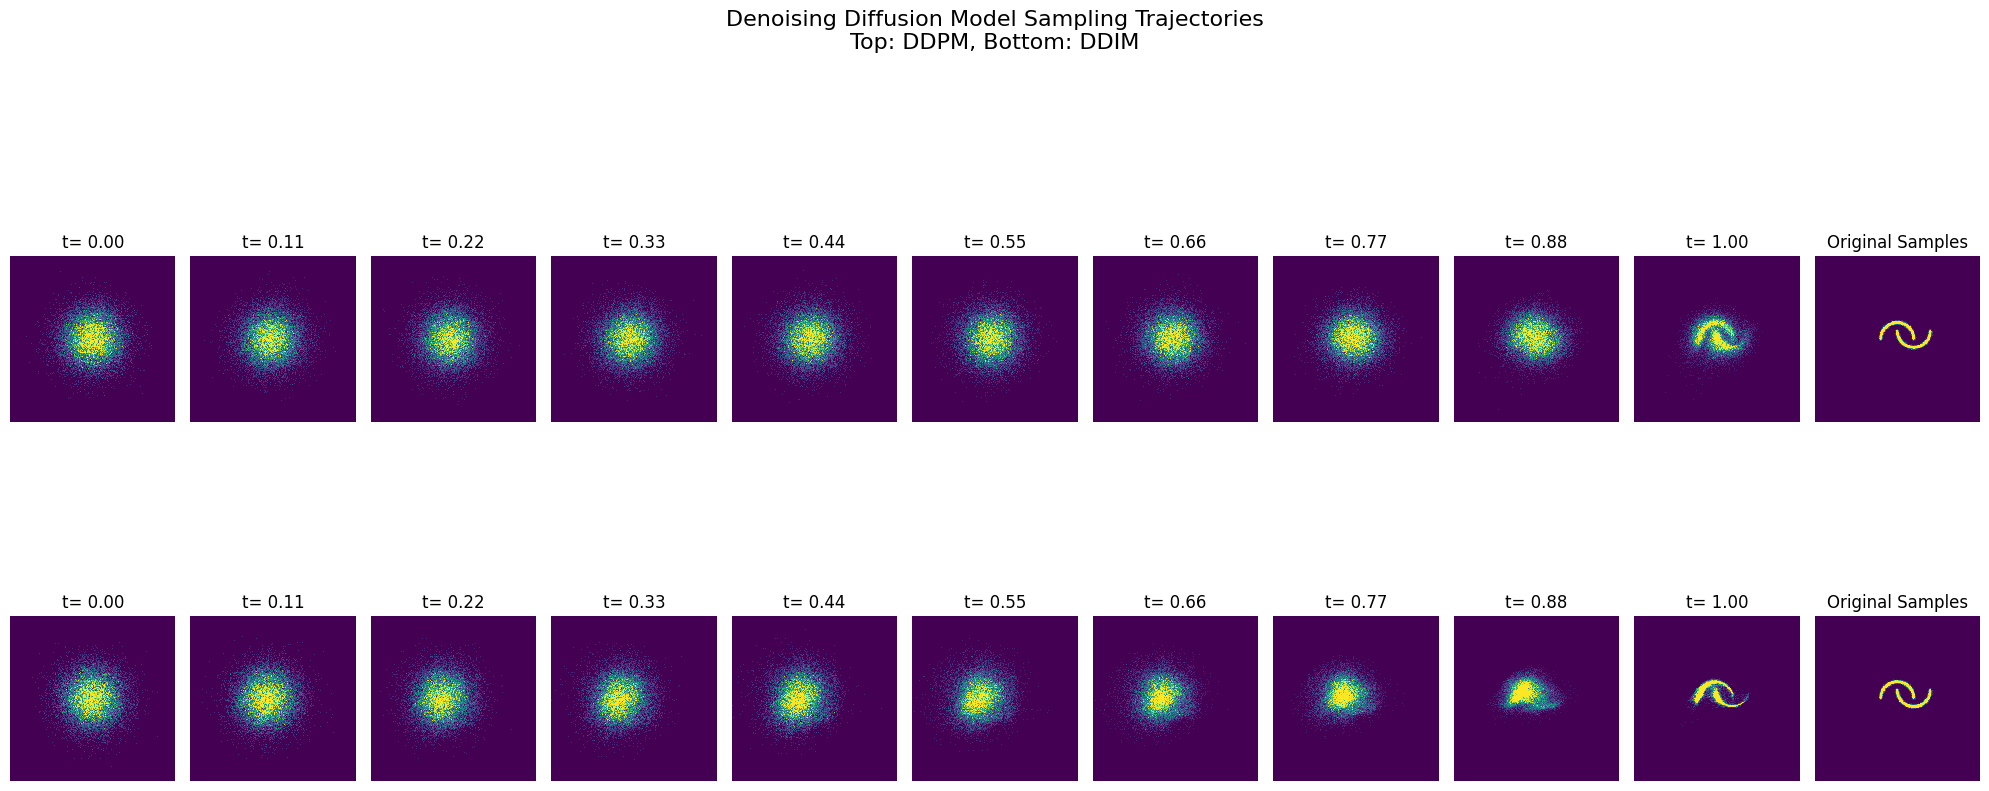

In [425]:
fig, axs = plt.subplots(2, 10 + 1,figsize=(20,10))
plot_timesteps = np.linspace(0, num_inf_steps-1, 10, dtype=int)
actual_timesteps = (plot_timesteps / (num_inf_steps - 1))  # normalized time [0,1]
sol_ddpm = np.array(samples_ddpm)[plot_timesteps]  # (10, num_samples, 2)
sol_ddim = np.array(samples_ddim)[plot_timesteps]  # (10, num_samples, 2)

for i in range(10 + 1):
    if i == 10:
        # plot original samples
        H= axs[0, i].hist2d(original_samples_np[:,0], original_samples_np[:,1], 300, range=((-5,5), (-5,5)))
        cmin = 0.0
        cmax = torch.quantile(torch.from_numpy(H[0]), 0.99).item()
        norm = cm.colors.Normalize(vmax=cmax, vmin=cmin)
        _ = axs[0, i].hist2d(original_samples_np[:,0], original_samples_np[:,1], 300, range=((-5,5), (-5,5)), norm=norm)
        axs[0, i].set_aspect('equal')
        axs[0, i].axis('off')
        axs[0, i].set_title('Original Samples')
        H= axs[1, i].hist2d(original_samples_np[:,0], original_samples_np[:,1], 300, range=((-5,5), (-5,5)))
        cmin = 0.0
        cmax = torch.quantile(torch.from_numpy(H[0]), 0.99).item()
        norm = cm.colors.Normalize(vmax=cmax, vmin=cmin)
        _ = axs[1, i].hist2d(original_samples_np[:,0], original_samples_np[:,1], 300, range=((-5,5), (-5,5)), norm=norm)
        axs[1, i].set_aspect('equal')
        axs[1, i].axis('off')
        axs[1, i].set_title('Original Samples')
        break
    
    H= axs[0, i].hist2d(sol_ddpm[i,:,0], sol_ddpm[i,:,1], 300, range=((-5,5), (-5,5)))
    cmin = 0.0
    cmax = torch.quantile(torch.from_numpy(H[0]), 0.99).item()
    norm = cm.colors.Normalize(vmax=cmax, vmin=cmin)
    _ = axs[0, i].hist2d(sol_ddpm[i,:,0], sol_ddpm[i,:,1], 300, range=((-5,5), (-5,5)), norm=norm)
    axs[0, i].set_aspect('equal')
    axs[0, i].axis('off')
    axs[0, i].set_title('t= %.2f' % (actual_timesteps[i]))
    
    H= axs[1, i].hist2d(sol_ddim[i,:,0], sol_ddim[i,:,1], 300, range=((-5,5), (-5,5)))
    cmin = 0.0
    cmax = torch.quantile(torch.from_numpy(H[0]), 0.99).item()
    norm = cm.colors.Normalize(vmax=cmax, vmin=cmin)
    _ = axs[1, i].hist2d(sol_ddim[i,:,0], sol_ddim[i,:,1], 300, range=((-5,5), (-5,5)), norm=norm)
    axs[1, i].set_aspect('equal')
    axs[1, i].axis('off')
    axs[1, i].set_title('t= %.2f' % (actual_timesteps[i]))
    
plt.suptitle('Denoising Diffusion Model Sampling Trajectories\nTop: DDPM, Bottom: DDIM', fontsize=16)
plt.tight_layout()
plt.show()

In [426]:
# Reconstruction-based Anomaly Detection with Denoising Diffusion Model
from sklearn.metrics import roc_auc_score, average_precision_score

mse_normal = []
mse_anomaly = []

sampler = 'ddim'  # 'ddpm' or 'ddim'

t_np = np.linspace(1, 999, 10).astype(int)  # perturbation times
print("Perturbation steps: ", t_np)
inference_steps = 400
scores_norm = []

for i in range(len(t_np)):
    t = t_np[i]
    total_mse_normal = 0.0
    total_mse_anomaly = 0.0
    num_normal_samples = 0
    num_anomaly_samples = 0
    scores_at_t = []
    gt_labels = []
    
    for (x, y) in test_loader:
        x = x.to(device)
        y = y.to(device)
        gt_labels.extend(y.detach().cpu().numpy().tolist())
        
        batch_size = x.shape[0]
        t_batch = torch.full((batch_size,), t, device=device, dtype=torch.long)
        
        # Add noise to x_0 to get x_t
        noise = torch.randn_like(x, device=device)
        x_t = diffusion.q_sample(x, t_batch, noise)
        
        # Reconstruct x_1 from x_t
        with torch.no_grad():
            if sampler == 'ddpm':
                x_1_recon = diffusion.sample_intermediates(x_t, t_start=t, num_steps=inference_steps, device=device, return_intermediates=False)
            elif sampler == 'ddim':
                x_1_recon = diffusion.ddim_reverse_intermediates(x_t, t_start=t, num_steps=inference_steps, device=device, return_intermediates=False)
            else:
                raise ValueError("Invalid sampler type. Choose 'ddpm' or 'ddim'.")
        mse = F.mse_loss(x_1_recon, x.cpu(), reduction='none').mean(dim=1)  # per-sample MSE
        scores_at_t.extend(mse.detach().cpu().numpy().tolist())
        for j in range(batch_size):
            if y[j] == 0:
                total_mse_normal += mse[j].item()
                num_normal_samples += 1
            else:
                total_mse_anomaly += mse[j].item()
                num_anomaly_samples += 1
    scores_norm.append(scores_at_t)
    scores_at_t = np.array(scores_at_t)
    roc_auc_t = roc_auc_score(gt_labels, scores_at_t)
    avg_precision_t = average_precision_score(gt_labels, scores_at_t)
    print(f"t={t}: ROC AUC={roc_auc_t:.4f}, Average Precision={avg_precision_t:.4f}")

Perturbation steps:  [  1 111 222 333 444 555 666 777 888 999]
t=1: ROC AUC=0.5068, Average Precision=0.3420


KeyboardInterrupt: 

In [427]:
# Inversion-based Anomaly Detection with Denoising Diffusion Model

num_inf_steps = [1, 2, 3, 4, 5, 6, 8, 10, 15, 20, 25, 50, 75, 100]

print(f"Denoising Diffusion Model Inversion Anomaly Detection Results on {dataset_title}:")

roc_aucs = []
avg_precisions = []
for num_steps in num_inf_steps:
    scores = []
    labels = []

    for (x, y) in test_loader:
        x = x.to(device)
        y = y.to(device)
        
        batch_size = x.shape[0]
        
        # Invert x_1 to x_0
        with torch.no_grad():
            x_0 = diffusion.ddim_forward(x, num_steps=num_steps, device=device, return_intermediates=False)
            scores_batch = np.linalg.norm(x_0.cpu().numpy(), axis=1)
            scores.extend(scores_batch.tolist())
            labels.extend(y.cpu().numpy().tolist())
            
    roc_auc = roc_auc_score(labels, scores)
    avg_precision = average_precision_score(labels, scores)
    roc_aucs.append(roc_auc)
    avg_precisions.append(avg_precision)
    
    print(f"Steps: {num_steps}, ", end='')
    print(f"ROC AUC: {roc_auc:.4f}, Average Precision: {avg_precision:.4f}")

Denoising Diffusion Model Inversion Anomaly Detection Results on Interleaved Moons:
Steps: 1, ROC AUC: 0.6170, Average Precision: 0.5374
Steps: 2, ROC AUC: 0.5669, Average Precision: 0.3784
Steps: 3, ROC AUC: 0.4475, Average Precision: 0.2825
Steps: 4, ROC AUC: 0.4088, Average Precision: 0.2674
Steps: 5, ROC AUC: 0.4070, Average Precision: 0.2669
Steps: 6, ROC AUC: 0.4107, Average Precision: 0.2680
Steps: 8, ROC AUC: 0.4203, Average Precision: 0.2719
Steps: 10, ROC AUC: 0.4315, Average Precision: 0.2765
Steps: 15, ROC AUC: 0.4523, Average Precision: 0.2847
Steps: 20, ROC AUC: 0.4622, Average Precision: 0.2887
Steps: 25, ROC AUC: 0.4667, Average Precision: 0.2905
Steps: 50, ROC AUC: 0.4732, Average Precision: 0.2927
Steps: 75, ROC AUC: 0.4735, Average Precision: 0.2925
Steps: 100, ROC AUC: 0.4728, Average Precision: 0.2921


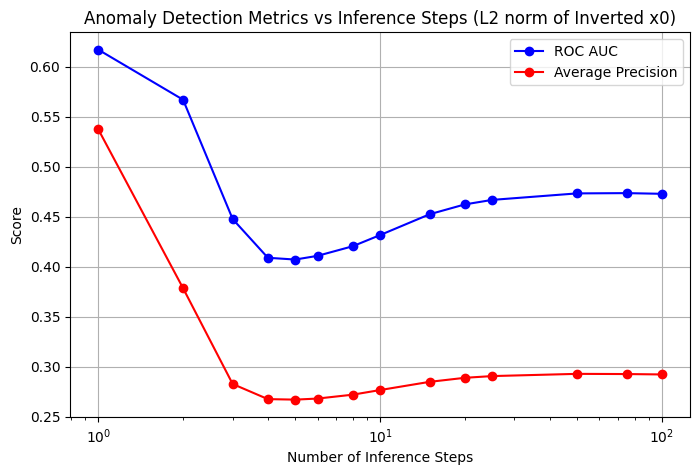

In [428]:
# Plot how AUC and AP vary with different inference steps
plt.figure(figsize=(8, 5))
plt.plot(num_inf_steps, roc_aucs, marker='o', label='ROC AUC', color='blue')
plt.plot(num_inf_steps, avg_precisions, marker='o', label='Average Precision', color='red')
plt.xscale('log')
plt.xlabel('Number of Inference Steps')
plt.ylabel('Score')
plt.title('Anomaly Detection Metrics vs Inference Steps (L2 norm of Inverted x0)')
plt.legend()
plt.grid(True)
plt.show()